# Stock Price Forecaster
## Machine Learning Engineer Nanodegree
**Calvin Ku**

**June 6, 2016**

## Definition

### Project Overview
The problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple forecaster is an attempt to solve this problem.

For any stock in S&P 500 (2009), the forecaster is able to predict the prices of that stock 21 days in the future. The precision of the forecast varies from stock to stock, but for the forecaster to be in anyway useful, generally we want to limit the error to be around 10% of the stock price.

#### Data used in this project
The datasets that will be used in this project include:
* Historical stock prices data collected from Yahoo Finance
* St. Louis Fed Financial Stress Index data

For the historical data, we will ready the stocks of S&P 500 (2009) range from January 1, 2009, to June 28, 2016. Some of the stocks are excluded due to not being traded as of this writing, data corruption, not propoerly adjusted, or not reliable.

### Problem Statement
This project is about building a stock price forecaster. The forecaster is built as a regressor, which tries to predict the price for a given stock for a given future date (for example, the price of GOOGL 10 days from now). The goal of this project is to build the forecaster that can predict the stock price 21 days from the day the prediction is made. We will use GOOGL as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method on GOOGL and 198 randomly picked stocks (to ensure 5% margin of errors at 95% confidence level) out of 410 stocks from S&P 500 (2009). The forecaster is meant be combined with a portfolio optimizer to form a total decisioning solution for trading to give trading suggustions to investors.


### Metrics
In this project we use MSE (mean sqauared error) as the metric, since our goal is to try to make the predicted price as close to the real price as possible. To be more specific, the reason why MSE is good is because:

1. The overestimations (when the predicted value is higher than the actual) and underestimations (when lower than the actual) of the model don't cancel out when you take the average, therefore you won't underestimate the error.

2. The square of a very small value is even smaller and the square of a big value is even bigger. We are looking for a model that can consistently make predictions that stay close to the actual, and with MSE, we can punish really off predictions even more (for example, being off by 20 is a lot more than twice as bad as being off by 10) to get a consistent model.

3. One problem with MSE is that it is more susceptible to outliers. Fortunately, the good thing about financial data is that the data is quite pristine so we can expect not so much corrupted and misinput data. On the other hand, unlike cross-sectional data, the continuous nature of stock price data itself eliminates the possibility of any "special case" and makes spotting corrupted data rather easy.

Along with MSE we also log the $R^2$. $R^2$ is the normalized MSE. And since it's normalized, it can give us a general idea when we try to compare the model performance across multiple stocks. 

## Analysis
### Data Exploration
About the data used in this project, we assume the following:

1.  CAPM (Capital Asset Pricing Model), where it states that any stock price on the market is a multitude (or a fraction) of the market trend (slope) $\beta$ (in our case, we use the stock price of SPY), plus a constant (intercept) $\alpha$ which is specific to that stock. 
2. Believing that economy is correlated to the the stock market
3. Believing that any price change without a good amount of volume behind is just a random fluctuation (Dow theory)

Therefore, the raw data used in this project includes the following:

* SPY Adj Close (assumption 1)
* SPY Volume (assumption 3)
* Adj Close of the target stock (our target variable)
* Volume of the target stock (assumption 3)
* STLFSI - St. Louis Fed Financial Stress Index data (assumption 2) generally measures the following:
    * An interest rate spread, such as the difference between yields on a “risky” asset (such as corporate bonds) and a “risk-free” asset (such as U.S. Treasuries), may be used to measure default risk.
    * Whether financial institutions are able to secure funding to finance short-term liabilities may indicate liquidity risk.
    
The benefit of STLFSI is that weekly series are used to have a more “real-time” index to measure rapid changes in the market. However, the tradeoff of having a higher-frequency index is greater volatility and potentially more noise. Also one reason STLFSI is picked is that it depicts the crash of 2008 fairly well, indicating that it might be a good index of predicting the stock market. For more details of the composition of the index, please refer to https://www.stlouisfed.org/news-releases/st-louis-fed-financial-stress-index/stlfsi-key
    
Since SPY is always traded in the trading days, we use it to get the trading days.

#### First look
Let's first take a glance at our data and see if there's any missing values. Again, in the demonstration, we use GOOGL as our example. The method can be applied to any other stocks.

In [109]:
from __future__ import division

# Data Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random
from IPython.display import display

# Set global random seeds
np.random.seed(0)
random.seed(0)

def load_data(stock_list_csv, market_csv, start_date, end_date, symbol_list=None, random_state=0, number_of_stocks=1, include_stocks=None):
    """The function does the following:
    1. Load the list of stocks
    2. Load the market data (SPY or other ETF data)
    3. Load the economy data (STLFSI or other index data)
    4. Randomly picks 10 stocks and load into a dictionary of dataframes if symbol_list is not provided,
       otherwise load the stocks in the symbo_list instead
    5. Return a dictionary of dataframes of stock data, with stock symbols as the keys
    """
    start_time = time.time()
    
    # Set up the empty main dataframe using the defined data range
    date_range = pd.date_range(start_date, end_date)
    df_main = pd.DataFrame(index=date_range)
    
    # Load SPY to get trading days
    dfSPY = pd.read_csv(market_csv, index_col='Date', parse_dates=True, usecols=['Date', 'Adj Close', 'Volume'], na_values = ['nan'])
    dfSPY = dfSPY.rename(columns={'Adj Close': 'SPY', 'Volume': 'SPY_Vol'})
    
    # Get SPY within the target date range
    df_main = df_main.join(dfSPY)
    
    # Drop NaN values
    df_main = df_main.dropna()
    
    # Load target stock list
    dfSPY500_2009 = pd.read_csv(stock_list_csv, header=None, usecols = [1])
    
    # Ready the symbol list
    if symbol_list is None:
#         np.random.seed(random_state)
        symbol_list = np.random.choice(dfSPY500_2009[1].tolist(), size=number_of_stocks, replace=False).tolist()
    
    if include_stocks is not None:
        try:
            symbol_list.extend(include_stocks)
            symbol_set = set(symbol_list)
            symbol_list = list(symbol_set)
        except TypeError:
            print("The stocks to be included should be put in a list.")

    
    # Load the FSI data
    dfFSI = pd.read_csv('STLFSI.csv', index_col='DATE', parse_dates=True, na_values = ['nan'])
    
    # Load target stocks
    result_dict = {}
    
    for symbol in symbol_list:
        if symbol != 'SPY':
            df_temp = pd.read_csv('stock_data/' + symbol + '.csv', index_col="Date", parse_dates=True, usecols = ['Date', 'Volume', 'Adj Close'], na_values=['nan'])
            df_temp = df_temp.rename(columns={'Volume': symbol + '_Vol', 'Adj Close': symbol})
            df_temp2 = df_main.join(df_temp, how='left')
            df_temp2 = df_temp2.join(dfFSI, how='left')
            result_dict[symbol] = {'original_data': df_temp2}
    
    print("{} seconds elapsed for loading data.".format(time.time() - start_time))
    print("\n")
    return result_dict

# Set stock
symbol = 'GOOGL'

# Set date range
start_date = '2009-01-01'
end_date = '2016-06-30'

# Load stock dataframes into dictionary
stock_dict = load_data('sp500_2009.csv', 'stock_data/SPY.csv', start_date, end_date, number_of_stocks=0, include_stocks=[symbol])

# Get target stock names
print("Stocks included:")
print(stock_dict.keys())

# Set example stock dataframe
df_main = stock_dict[symbol]['original_data']

# First glance at the data
display(df_main.head())

# Inspect missing values
print("Inspect missing values:")
print(df_main.isnull().sum())


0.0324199199677 seconds elapsed for loading data.


Stocks included:
['GOOGL']


SPY_Vol        SPY  GOOGL_Vol       GOOGL  STLFSI
2009-01-02  227566300.0  79.602650    7213700  160.820818   3.643
2009-01-05  240349700.0  79.508455    9768200  164.189196     NaN
2009-01-06  328260900.0  80.039370   12837500  167.197207     NaN
2009-01-07  280899200.0  77.641697    8980000  161.166170     NaN
2009-01-08  263834400.0  77.958535    7194100  162.757754     NaN

Inspect missing values:
SPY_Vol         0
SPY             0
GOOGL_Vol       0
GOOGL           0
STLFSI       1510
dtype: int64


We can see that we don't have any missing values to be taken care of for GOOGL. The financial stress index is calculated weekly so we'll have to fill in for the dates between the calculations ourselves.

#### A closer look
Now let's take a look at the statistics of the stock price data.

In [110]:
# Inspect the stock price column
n_days = df_main.shape[0]
min_price = df_main[symbol].min()
max_price = df_main[symbol].max()
mean_price = df_main[symbol].mean()
median_price = np.median(df_main[symbol])
std_price = df_main[symbol].std()
cv = std_price / mean_price

print("Number of traded days: {}".format(n_days))
print("Minimum stock price: {}".format(min_price))
print("Maximum stock price: {}".format(max_price))
print("Mean stock price: {}".format(mean_price))
print("Median stock price: {}".format(median_price))
print("Standard deviation of stock price: {}".format(std_price))
print("Coefficient of variation of stock price: {}".format(cv))

Number of traded days: 1885
Minimum stock price: 141.516512
Maximum stock price: 793.960022
Mean stock price: 412.004713227
Median stock price: 340.700719
Standard deviation of stock price: 170.050499998
Coefficient of variation of stock price: 0.41273921035


We can see that we don't have any outliers here in the stock price data. And the coefficient of variation is less than 1.

Let's inspect the statistics of other features.

In [111]:
# Inspect all columns
display(df_main.describe())

SPY_Vol          SPY     GOOGL_Vol        GOOGL      STLFSI
count  1.885000e+03  1885.000000  1.885000e+03  1885.000000  375.000000
mean   1.645517e+08   142.012669  4.650994e+06   412.004713   -0.677891
std    8.730687e+07    43.102172  3.120021e+06   170.050500    0.992101
min    3.731780e+07    58.323328  5.206000e+05   141.516512   -1.655000
25%    1.040035e+08   105.351470  2.439400e+06   277.122135   -1.300500
50%    1.437597e+08   130.852555  4.097400e+06   340.700719   -0.916000
75%    2.023543e+08   187.428955  5.807300e+06   552.510010   -0.482000
max    7.178287e+08   211.271298  2.961990e+07   793.960022    3.643000

Here we can see that the distribution of our data are generally skewed and the scales for different features are wildly different.

To better see this, let's view our data in visual.

### Exploratory Visualization
First let's have a look at our target variable:

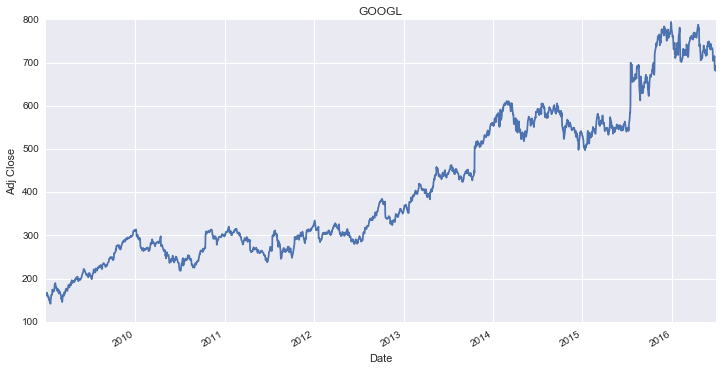

In [112]:
# Inspect stock trend
ax = df_main[symbol].plot(title=symbol, figsize=(12, 6))
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a557290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1466b2150>]], dtype=object)

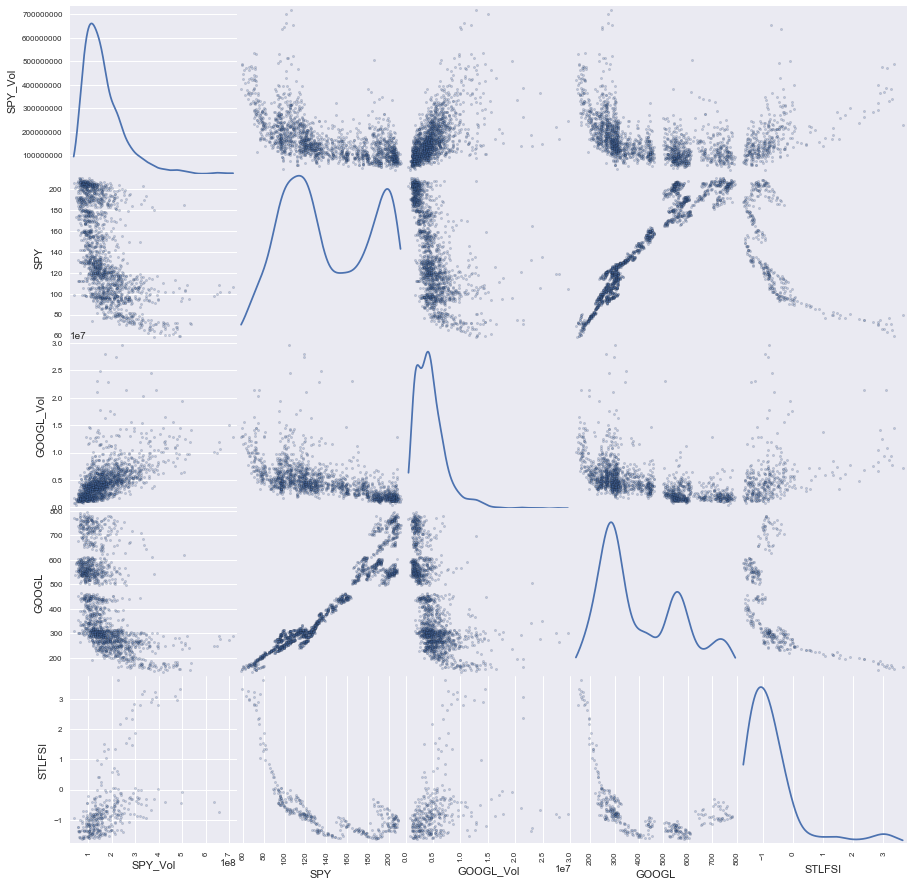

In [113]:
from pandas.tools.plotting import scatter_matrix

# Save time during Dev

scatter_matrix(df_main, alpha=0.3, figsize=(15, 15), diagonal='kde')


# g = sns.PairGrid(df_main)
# g.map_upper(plt.scatter, alpha=0.3)
# g.map_lower(plt.scatter, alpha=0.3)
# g.map_diag(sns.kdeplot, lw=3, legend=False)

# plt.subplots_adjust(top=0.95)
# g.fig.suptitle('Feature Pair Grid')

We can see really clear correlations among SPY, GOOGL and STLFSI. However, most of the features in our dataset are not normally distributed, and the scales differ wildly. We can't visualize the density graphs well in this plot before we apply feature scaling. A common practice for sovling problems like this for financial data is to apply non-linear transformation to the data. Since some of our features have negative values, we can use a modified version of logorithm transform, the signed logorithm transform to our dataset.

### Algorithms and Techniques
#### Algorithms
In this project we will use the random forest algorithm to model our data. The random and ensemble nature of the algorithm makes it very unlikely to overfit on the training data. Furthermore, random forest is very easy to tune. We can easily grid search through the number of choice of features for each splitting and the number of trees. In addition to this, the ensemble nature of the algorithm makes it scalable when we need to: 1. train on more data, 2. build more trees, 3. include more stocks to forecast. Overall, random forest generally gives good results and it has been recognized that ensemble algorithms like random forest perform over other traditional regression algorithms in the Kaggle community over the years.

##### How random forest works
As stated earlier, the random forest is an ensemble method, which "ensembles" a bunch of decision trees. Each decision tree is generated by creating "nodes" with features in our dataset. 

##### Decision tree
In the training stage, a data point comes down and through the nodes of the decision tree. Each node classifies the data point and sends it to the next node. Say, for example we are classifying people to determine whether their annual income is above or below average, and one feature of our data is gender. And we will probably have values like male/female/other. Now say this data point is a female, then it will get sent down the path accordingly to the next node. The node at the bottom of the decision tree is sometimes referred to as a leaf. Our data point will end up in one of the leaves, and the label of the data point is going to mark that leaf. For example, if our data point is above income average, then we mark that leaf as "above count +1". At the end of the training, all leaves will be marked with labels above or below.

In the predicting stage, we run data down the decision tree and see which leaves they end up with. And then we assign the data the labels of the leaves accordingly.

##### Ensemble
We now know how each decision tree is constructed, and have a forest of decision trees. The last step is to get these decision trees to vote. If 10 trees say this person is above and 5 say below, we predict the person as above. 

##### Randomness of random forest
As said earlier, the decision trees are constructed with the features of our dataset. However, not all of the features are used to construct each decision tree. This is where the random part of the algorithm comes in. Most implementation employs a method called bagging, which generates $m$ sub-datasets from the feature space of the orginal dataset by sampling with replacement, where the size of the sub-datasets is $n'$, relative to the size of the feature space of the original dataset, $n$. The features of each bag are then used to construct a decision tree model.

##### Other parts of random forest
We won't cover everything about the random forest here. However it's worth noting some of the more important specifics of random forest that are not covered here:
* Binning of the continuous variables—which are done slightly differently from implementation to implementation
* Splitting methods—when constructing the decision trees we need to decide which feature to be placed on top of the tree and which to be put at the bottom. 
* Voting methods—we can decide to give each decision tree with the same voting power, or not.
* Modification of the algorithm for regression problems (recursive partitioning)

#### Other techniques
##### Training data with "rolling training"
The part where stock market forecasting really differs from a lot of problems is that we are dealing with a highly time-dependent system. This means the data we collect for training is only valid within a range of time. In this project we will choose 100 days as our window size. For each data point we try to predict it's stock price by the model built only with the data from the past 121 days to the past 21 days, and move that window forward to predict for the next date. 

### Benchmark
The model will be checked against the following models:

* Simple average model
* Naive model
* Drift model

We aim to beat all of the models above to justify our model complexity. On the other hand, we argue that a model is only practically useful if given a prediction interval, the mean and median of the voilatility of that interval of a specific stock is larger than our prediction error. More rigorously:

Given a stock S, with price P(S, t) and a prediction interval I, if the 70th percentile of |P(S, t + I) - P(S, t) / P(S, t)| > 1.282 sigma_errp (assuming the mean_errp = 0) for all t, then there will be 55% of chance that if we long/short at time t according to our forecast, we can make a profit of it.

## Methodology
### Data Preprocessing
#### Treating missing values
As discussed earlier, we have 1510 records missing for STLFSI due to how it is weekly calculated. We need to forward fill (to prevent the problem of peeking-into-the-future) and then back fill for days where the data is unavailable.

In [114]:
### Forward/Back Fill missing data
def fill_missing_data(stock_dict):
    for stock_name in stock_dict:
        stock_dict[stock_name]['original_data'].fillna(method='ffill', inplace=True)
        stock_dict[stock_name]['original_data'].fillna(method='bfill', inplace=True)

    return stock_dict

stock_dict = fill_missing_data(stock_dict)

# Update the main stock
df_main = stock_dict[symbol]['original_data']

## Display
# df_main[symbol].plot()
display(df_main.head(10))
print(df_main.isnull().sum())

SPY_Vol        SPY  GOOGL_Vol       GOOGL  STLFSI
2009-01-02  227566300.0  79.602650    7213700  160.820818   3.643
2009-01-05  240349700.0  79.508455    9768200  164.189196   3.643
2009-01-06  328260900.0  80.039370   12837500  167.197207   3.643
2009-01-07  280899200.0  77.641697    8980000  161.166170   3.643
2009-01-08  263834400.0  77.958535    7194100  162.757754   3.643
2009-01-09  330953600.0  76.288725    8672300  157.692690   3.171
2009-01-12  277858500.0  74.456220    6601900  156.501497   3.171
2009-01-13  356432300.0  74.593233    8856100  157.317324   3.171
2009-01-14  435491600.0  72.246943   10924800  150.635637   3.171
2009-01-15  532647300.0  72.272632   11857100  149.644640   3.171

SPY_Vol      0
SPY          0
GOOGL_Vol    0
GOOGL        0
STLFSI       0
dtype: int64


#### Priliminary feature scaling and creating labels
As discussed earlier, we can do a simple signed-log tranform to our data to bring all features to the same scale. The non-linear nature of the transform also helps normalize the data which is crucial for many machine learning algorithms.

##### Create and separate out labels
Since we don't need to apply feature scaling to the labels (target variable), we will separate it out first. Our goal is to predict prices 21 days from the day of prediction. We can use pandas shift method to achieve this.

In [115]:
## Split and create label data
def split_data(stock_dict):
    for stock_name in stock_dict:
        stock_dict[stock_name]['original_data_y'] = stock_dict[stock_name]['original_data'][stock_name]

    return stock_dict

## Apply n-day shift to data
def create_n_day_forecast_data(df, symbol, day):
    df = df.shift(-day)
    return df

## Add label_name key to dictionary for the feature engineering stage
def add_label_name_to_stock_dict(stock_dict, window):
    for stock_name in stock_dict:
        stock_dict[stock_name]['label_name'] = stock_name + str(window) + 'd'
    return stock_dict

## Assign the generated labels to 'data_y'
def create_label_data(stock_dict, window):
    for stock_name in stock_dict:
        stock_dict[stock_name]['data_y'] = create_n_day_forecast_data(stock_dict[stock_name]['original_data_y'], stock_name, window)
    return stock_dict

def ready_label_data(stock_dict, window):
    stock_dict = split_data(stock_dict)
    stock_dict = add_label_name_to_stock_dict(stock_dict, window)
    stock_dict = create_label_data(stock_dict, window)
    
    return stock_dict

# Ready label data
window = 5
stock_dict = ready_label_data(stock_dict, window)

for stock_name in stock_dict:
    stock_dict[stock_name]['data_y'].dropna(inplace=True)

label_name = stock_dict[symbol]['label_name']
original_data_y = stock_dict[symbol]['original_data_y']
data_y = stock_dict[symbol]['data_y']

##### Preliminary feature scaling
The reader may have noticed we are keeping the price data. This is because we will need it for the feature engineering stage, thus we are keeping it and also scaling it along with other features.

0.00275588035583 seconds elapsed for log transforming data.


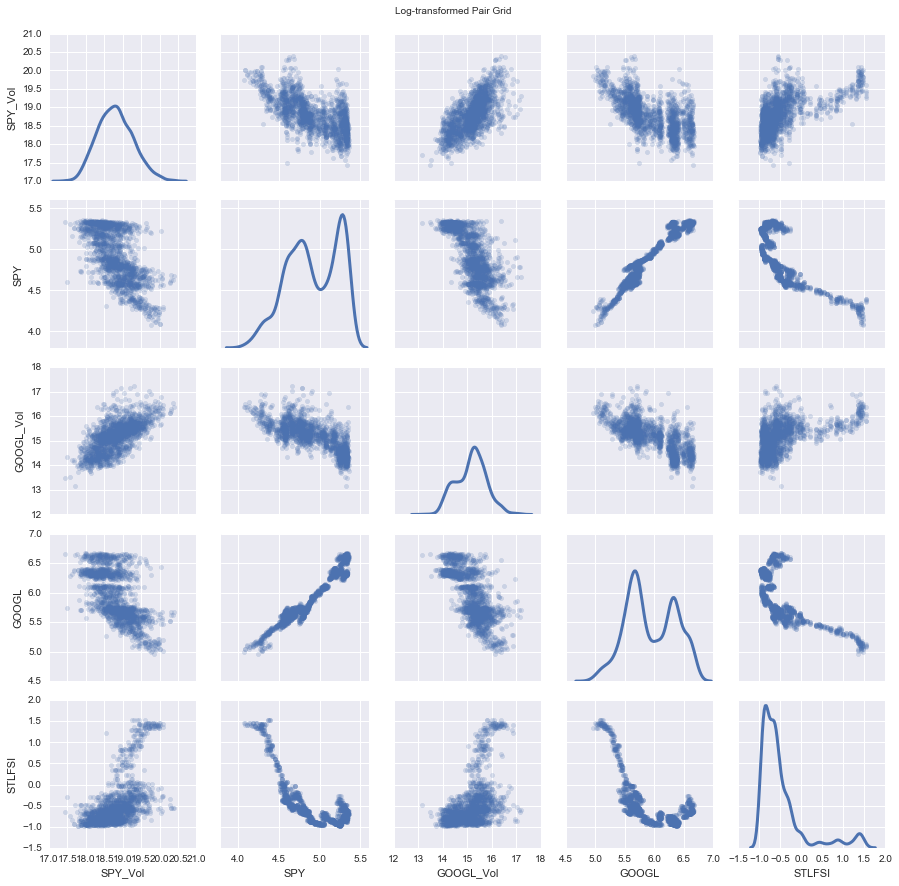

In [116]:
# Signed-log transform
def sign_log(df):
    return np.sign(df) * np.log(abs(df) + 1)
    
log_start_time = time.time()
for stock_name in stock_dict:
    stock_dict[stock_name]['log_data'] = sign_log(stock_dict[stock_name]['original_data'])
#     stock_dict[stock_name]['log_data'] = np.sign(stock_dict[stock_name]['original_data']) * np.log(abs(stock_dict[stock_name]['original_data']) + 1)

log_data = stock_dict[symbol]['log_data']
print("{} seconds elapsed for log transforming data.".format(time.time() - log_start_time))

# Save time during Dev
g = sns.PairGrid(log_data)
g.map_upper(plt.scatter, alpha=0.2)
g.map_lower(plt.scatter, alpha=0.2)
g.map_diag(sns.kdeplot, lw=3, legend=False)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Log-transformed Pair Grid')

Now the trends have become more clear. Not only can we see very clean-cut relationships between GOOGL and SPY but also good correlations between stock prices and stock volumes, and prices and the STLFSI.

This lays a good foundation for us to do further feature engineering for our data.

#### Feature engineering
In this section we add a few features and remove some raw ones. The following are the complete feature list:

* **STLFSI: **St. Louis Fed Financial Stress Index data (foward filled) 
* **Beta (63 days): **$\beta = \frac{Cov(r_a, r_b)}{Var(r_b)}$
* **EMA (100 days): **$EMA_{today} = EMA_{yesterday} + \alpha \times (price_{today} - EMA_{yesterday}) \ \text{where }\alpha = \frac{2}{N+1}$
* **MMA: ** $MMA_{today} = \frac{(N-1) \times MMA_{yesterday} + price}{N}$
* **SMA (100 days): ** $SMA_{today} = \frac{\Sigma\ prices}{\text{number of days}}$
* **Price Momentum (100 days): ** $\frac{Momentum}{N + 1} = SMA_{today} - SMA_{yesterday}$
* **SP500 SMA Change (100 days): ** $SMA_{today} - SMA_{yesterday} = \frac{P_M - P_{M-n}}{n}$
* **SP500 Volatility (63 days): ** $Std(r_{SP})$
* **Sharpe Ratio (63 days): ** $\text{Sharpe Ratio} = \frac {r_a - r_{SP}}{\sigma_{r_a}}$
* **Volatility (63 days): ** $\sigma_{r_a}$
* **Volume Momentum (100 days): ** $\frac{\text{Volume Momentum}}{N + 1} = Volume_{today} - Volume_{yesterday}$
* **Volume Marker 1: ** 
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume Momentum} \geqslant 0\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$
* **Volume Marker 2: **
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume is greater than the mean + standard deviation}\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$
* **Volume Marker 3: **
$
              \left\{
                \begin{array}{ll}
                  1, \ \text{if Volume is greater than the mean - standard deviation}\\
                  0, \ \text{otherwise}
                \end{array}
              \right.
$

7.92499685287 seconds elapsed for feature engineering.


GOOGL_Vol    STLFSI  GOOGL_Std63d  GOOGL_Beta  GOOGL_EMA  \
2009-05-29  15.481537  0.938052      0.004201    0.982632   5.346268   
2009-06-01  15.708336  0.938052      0.004127    0.952905   5.368279   
2009-06-02  15.472195  0.938052      0.004121    0.950854   5.372564   
2009-06-03  15.769743  0.938052      0.004075    0.991606   5.380087   
2009-06-04  15.799116  0.938052      0.003913    0.969578   5.399792   

            GOOGL_MMA  GOOGL_SMA  GOOGL_SMA_Momentum  GOOGL_Vol_Momentum  \
2009-05-29   5.161414   5.181363            0.259779           -0.781512   
2009-06-01   5.163483   5.183949            0.261188           22.906757   
2009-06-02   5.165574   5.186398            0.247427          -23.850313   
2009-06-03   5.167719   5.189284            0.291465           30.052397   
2009-06-04   5.170040   5.192268            0.301404            2.966613   

            GOOGL_Vol_M1  GOOGL_Vol_M2  GOOGL_Vol_M3  GOOGL_SR63d  \
2009-05-29           0.0           0.0           0.0     0.153166   
2009-06-01           1.0           0.0           1.0     0.195960   
2009-06-02           0.0           0.0           0.0     0.203206   
2009-06-03           1.0           0.0           1.0     0.226397   
2009-06-04           1.0           0.0           1.0     0.284375   

            SPY_SMA_Momentum  SPY_Std63d   GOOGL5d  
2009-05-29          0.002465    0.005229  5.408885  
2009-06-01          0.027261    0.005037  5.396372  
2009-06-02          0.021522    0.005025  5.389200  
2009-06-03          0.038978    0.005017  5.382275  
2009-06-04          0.044196    0.004819  5.373957

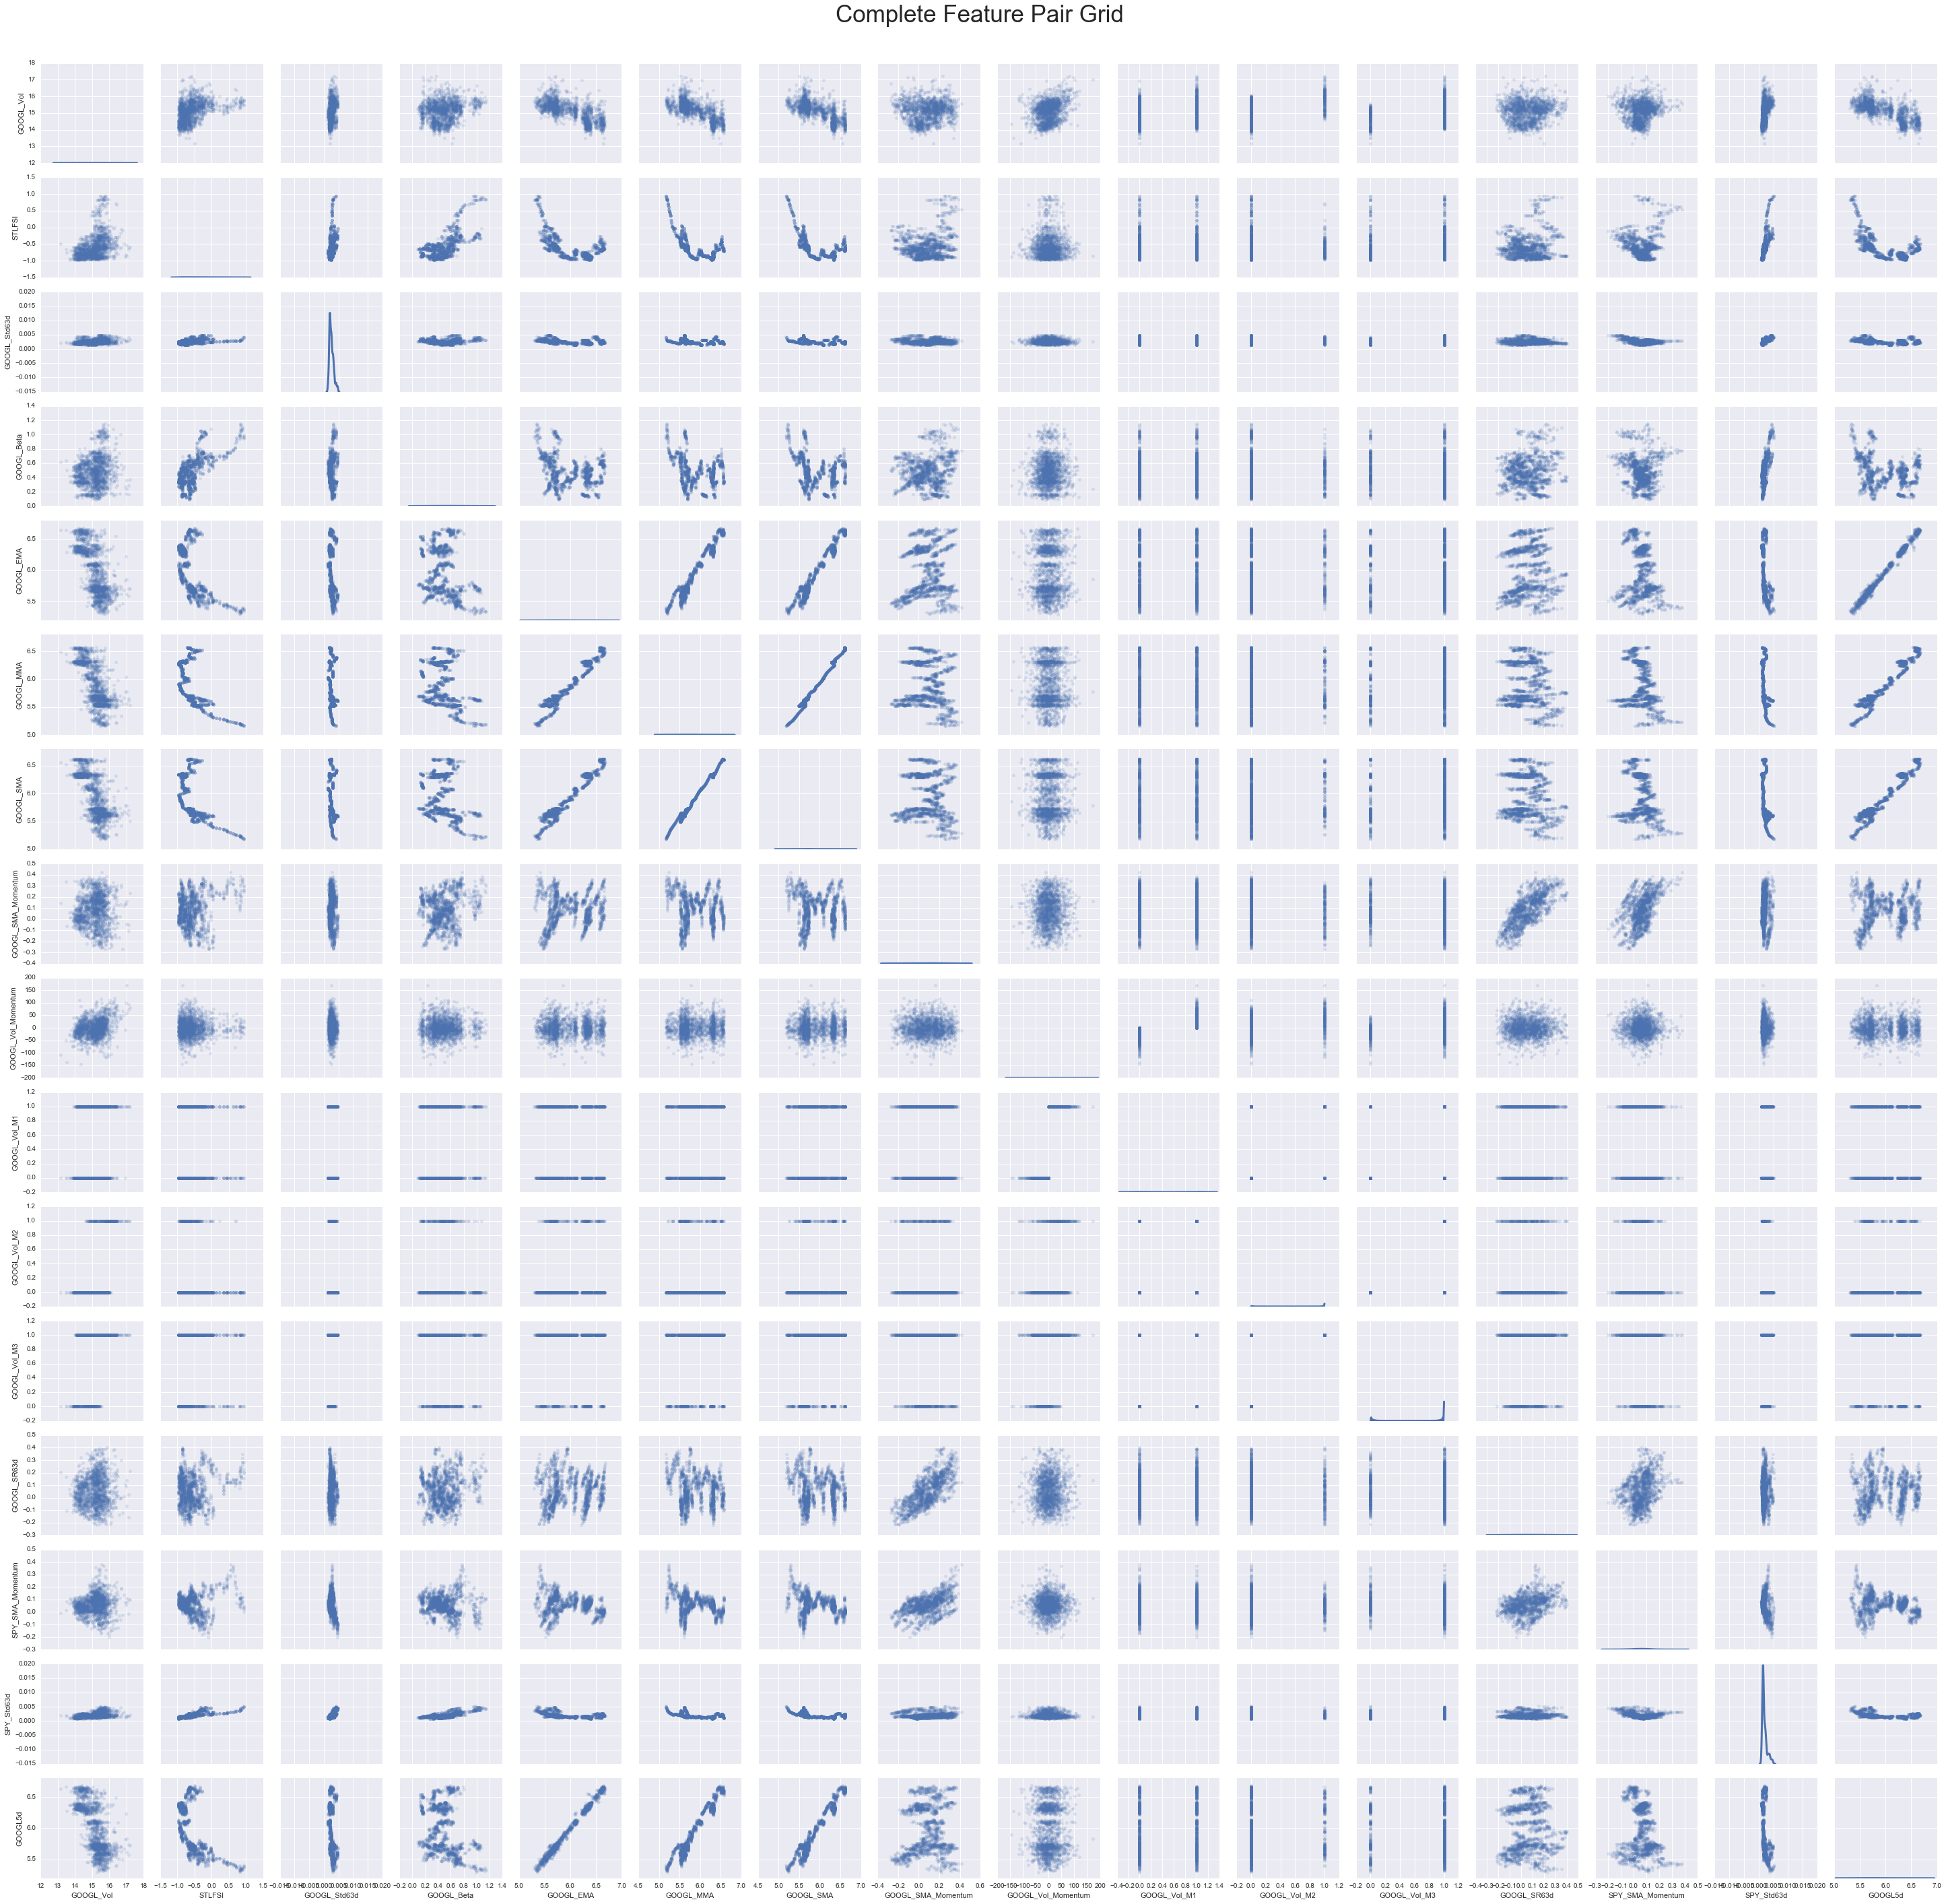

In [117]:
### Feature Engineering Section
### Make Daily Return Columns
def compute_daily_returns(df, adj_close_name):
    return (df / df.shift(1) - 1)[adj_close_name]

def make_daily_return_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)

    for symbol in symbols:
        df[symbol + '_return'] = compute_daily_returns(df, symbol)

    return df

### Make Beta columns (63 days)
def make_mean_std_columns(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    mean_dict = {}
    std_dict = {}

    for symbol in symbols:
        mean_dict[symbol] = []
        std_dict[symbol] = []

        for i in df.index:
            (u,) = df.index.get_indexer_for([i])
            if u - 63 >= 0:
                mean_dict[symbol].append(df[symbol + '_return'].iloc[u - 62:u+1].mean())
                std_dict[symbol].append(df[symbol + '_return'].iloc[u - 62:u+1].std())
            else:
                mean_dict[symbol].append(np.nan)
                std_dict[symbol].append(np.nan)

        df[symbol + '_Mean63d'] = mean_dict[symbol]
        df[symbol + '_Std63d'] = std_dict[symbol]

    return df

def make_beta_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    cov_dict = {}

    for symbol in symbols:
        cov_dict[symbol] = []
        for i in df.index:
            (u,) = df.index.get_indexer_for([i])
            if u - 62 >= 0:
                cov_dict[symbol].append(df['SPY_return'].iloc[(u - 62):u+1].cov(df[symbol + '_return'].iloc[(u - 62):u+1]))
            else:
                cov_dict[symbol].append(np.nan)
        df[symbol + '_Cov63d'] = cov_dict[symbol]
        df[symbol + '_Beta'] = df[symbol + '_Cov63d'] / df[symbol + '_Std63d']**2

    return df

### Make EMA column (100 days)
def make_ema_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)

    EMA_dict = {}
    alpha = 2 / (100 + 1)

    for symbol in symbols:
        EMA_dict[symbol] = []
        EMA_dict[symbol].append(df[symbol].iloc[0])

        for i in df.index[1:]:
            (u,) = df.index.get_indexer_for([i])
            EMA_dict[symbol].append(EMA_dict[symbol][u - 1] + alpha * (df[symbol].iloc[u] - EMA_dict[symbol][u - 1]))

        df[symbol + '_EMA'] = df[symbol]
    
    return df

### Make MMA column (100 days)
def make_mma_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    MMA_dict = {}
    alpha = 1 / 100

    for symbol in symbols:
        MMA_dict[symbol] = []
        MMA_dict[symbol].append(df[symbol].iloc[0])

        for i in df.index[1:]:
            (u,) = df.index.get_indexer_for([i])
            MMA_dict[symbol].append(MMA_dict[symbol][u - 1] + alpha * (df[symbol].iloc[u] - MMA_dict[symbol][u - 1]))

        df[symbol + '_MMA'] = MMA_dict[symbol]

    return df    

# ### Make SMA column (100 days)
def make_sma_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
            df[symbol + '_SMA'] = df[symbol].rolling(window=101, center=False).mean()

    return df

### SMA Momentum
def compute_SMA_momentum(df, SMA_column):
    return (df - df.shift(1))[SMA_column]*(100 + 1)

def make_sma_momentum_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SMA_Momentum'] = compute_SMA_momentum(df, symbol + '_SMA')

    return df

### Volume Momentum
def compute_Volume_momentum(df, Volume_column):
    return (df - df.shift(1))[Volume_column]*(100 + 1)

def make_vol_momentum_column(symbol, df):
    df[symbol + '_Vol_Momentum'] = compute_Volume_momentum(df, symbol + '_Vol')
    
    return df

### Vol_Momentum Marker 1
def make_vol_momentum_marker1_column(symbol, df):
    df[symbol + '_Vol_M1'] = np.nan
    df.loc[df[symbol + '_Vol_Momentum'] >= 0, symbol + '_Vol_M1'] = 1
    df.loc[df[symbol + '_Vol_Momentum'] < 0, symbol + '_Vol_M1'] = 0

    return df

### Vol_Momentum Marker 2
def make_vol_momentum_marker2_column(symbol, df):
    df[symbol + '_Vol_M2'] = np.nan
    df.loc[df[symbol + '_Vol'] >= (df[symbol + '_Vol'].rolling(window=101, center=False).mean() + df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 1
    df.loc[df[symbol + '_Vol'] < (df[symbol + '_Vol'].rolling(window=101, center=False).mean() + df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M2'] = 0

    return df

### Vol_Momentum Marker 3
def make_vol_momentum_marker3_column(symbol, df):
    df[symbol + '_Vol_M3'] = np.nan
    df.loc[df[symbol + '_Vol'] < (df[symbol + '_Vol'].rolling(window=101, center=False).mean() - df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 0
    df.loc[df[symbol + '_Vol'] >= (df[symbol + '_Vol'].rolling(window=101, center=False).mean() - df[symbol + '_Vol'].rolling(window=101, center=False).std()), symbol + '_Vol_M3'] = 1
    
    return df

### Make SR column
def make_SR_column(symbol, df):
    symbols = ['SPY']
    symbols.append(symbol)
    
    for symbol in symbols:
        df[symbol + '_SR63d'] = df[symbol + '_return'].rolling(window=63, center=False).mean() / df[symbol + '_Std63d']
    
    return df

### Drop not used SPY columns    
### Put back SPY keeper
def drop_keep_SPY_columns(symbol, df):
    ### Drop not used SPY columns    
    SPY_keeper = df[['SPY_SMA_Momentum', 'SPY_Std63d']]

    for column in df.columns:
        if 'SPY' in column:
            df.drop([column], axis=1, inplace=True)

    ### Put back SPY keeper
    df = pd.concat([df, SPY_keeper], axis=1)

    return df

### Drop not used columns
### Drop NaN rows
def drop_unused_nan_columns(symbol, df):
    ### Drop not used columns
    try:
#         df.drop([symbol, symbol + '_return', symbol + '_Mean63d', symbol + '_Cov63d', symbol + '_Vol'], axis=1, inplace=True)
        df.drop([symbol, symbol + '_return', symbol + '_Mean63d', symbol + '_Cov63d'], axis=1, inplace=True)
    except ValueError:
        print('OK, seems like these columns are already gone...')
    
    ### Drop NaN rows
    df.dropna(inplace=True)
        
    return df

def feature_engineer(symbol, df):    
    df = make_daily_return_column(symbol, df)
    df = make_mean_std_columns(symbol, df)
    df = make_beta_column(symbol, df)
    df = make_ema_column(symbol, df)
    df = make_mma_column(symbol, df)
    df = make_sma_column(symbol, df)
    df = make_sma_momentum_column(symbol, df)
    df = make_vol_momentum_column(symbol, df)
    df = make_vol_momentum_marker1_column(symbol, df)
    df = make_vol_momentum_marker2_column(symbol, df)
    df = make_vol_momentum_marker3_column(symbol, df)
    df = make_SR_column(symbol, df)
    df = drop_keep_SPY_columns(symbol, df)
    df = drop_unused_nan_columns(symbol, df)
    
    return df

feature_eng_start_time = time.time()

for stock_name in stock_dict:
    stock_dict[stock_name]['log_data'] = feature_engineer(stock_name, stock_dict[stock_name]['log_data'])
    stock_dict[stock_name]['data_X'] = stock_dict[stock_name]['log_data']
    stock_dict[stock_name]['data_y'] = stock_dict[stock_name]['data_y'].ix[stock_dict[stock_name]['data_X'].index]
    stock_dict[stock_name]['data_y'].dropna(inplace=True)
    stock_dict[stock_name]['data_X'] = stock_dict[stock_name]['data_X'].ix[stock_dict[stock_name]['data_y'].index]

print("{} seconds elapsed for feature engineering.".format(time.time() - feature_eng_start_time))

log_data = stock_dict[symbol]['log_data']
data_X = stock_dict[symbol]['data_X']
data_y = stock_dict[symbol]['data_y']

# Inspect the scatter matrix (full)
data_y_temp = data_y.copy().rename(columns=[label_name])
full_data = data_X.copy()
full_data[label_name] = np.sign(data_y_temp) * np.log(abs(data_y_temp) + 1)
display(full_data.head())

g = sns.PairGrid(full_data)
g.map_upper(plt.scatter, alpha=0.15)
g.map_lower(plt.scatter, alpha=0.15)
g.map_diag(sns.kdeplot, lw=3, legend=False)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Complete Feature Pair Grid', fontsize = 35)

From the scatter matrix we can clearly see EMA, MMA and SMA are showing good correlations with the target variables, STLFSI is also showing some trend. This tells us that we're not too far off the track.

## Implementation
In this section we will train our model and backtest it with the metrics we have defined earlier.

#### Rolling Training
As mentioned earlier, due to the nature of time series data, we will use a different method than our usual way with cross-sectional data. As said in the earlier section, we will use 100 days for our window size. For each data point we try to predict its stock price by the model built only with the data from the past 121 days (with a 21-day gap), and move that window forward to predict for the next date. Note that our label is not the stock price of the day of predition, but 21 trading days from that day.

#### Random Forest Default Parameters
To start with we will use the default parameters given in the Python sklearn package:
* Number of trees: 10
* Max number of features in each tree: 14 (size of the feature space)
* Bootstrap samples are used for building trees

Note that due to the stochastic nature of the algorithm, we have set a global random seed = 0 to make sure the reproducibility of the result.

Creating test_y: 1658
Creating pred_y: 1658
Creating pred_y: 1658
2009-11-18    293.163181
2009-11-19    290.170170
2009-11-20    291.791782
2009-11-23    295.230228
2009-11-24    294.049046
2009-11-25    293.163181
2009-11-27    292.797794
2009-11-30    293.418430
2009-12-01    293.818821
2009-12-02    294.804813
2009-12-03    296.046055
2009-12-04    295.550541
2009-12-07    298.163181
2009-12-08    296.866856
2009-12-09    299.179173
2009-12-10    297.267277
2009-12-11    298.508518
2009-12-14    299.639652
2009-12-15    300.860874
2009-12-16    306.146153
2009-12-17    309.549565
2009-12-18    311.746739
2009-12-21    310.010014
2009-12-22    311.676670
2009-12-23    310.300297
2009-12-24    313.688694
2009-12-28    312.307316
2009-12-29    304.434452
2009-12-30    297.347355
2009-12-31    301.311314
                 ...    
2016-05-10    720.190002
2016-05-11    721.780029
2016-05-12    715.309998
2016-05-13    721.710022
2016-05-16    717.250000
2016-05-17    733.030029
2016-05-1

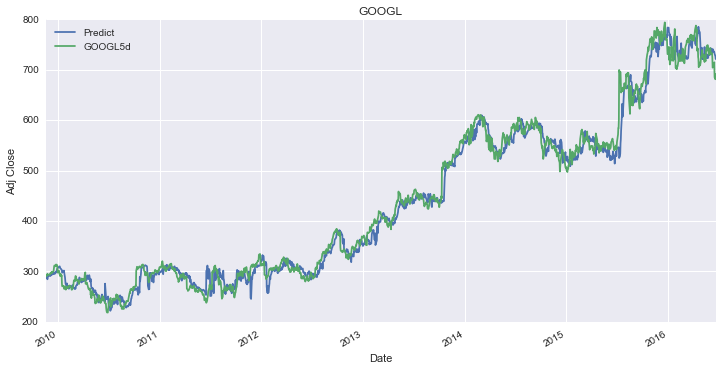

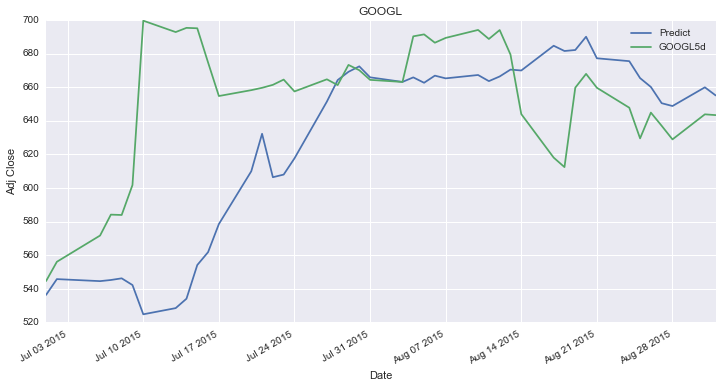

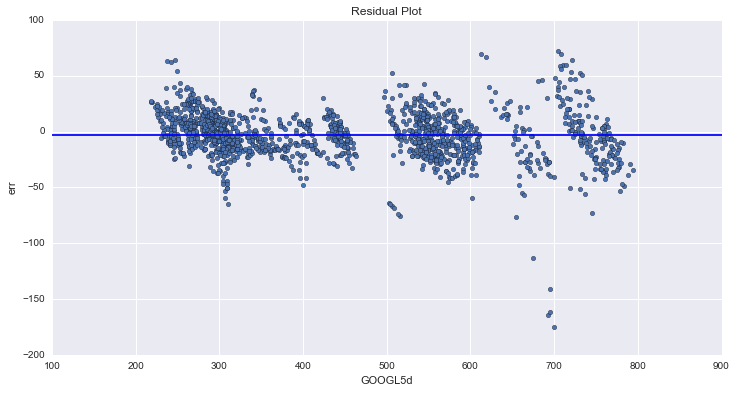

Err mean: -2.92758205603
Err Std: 20.4399391822


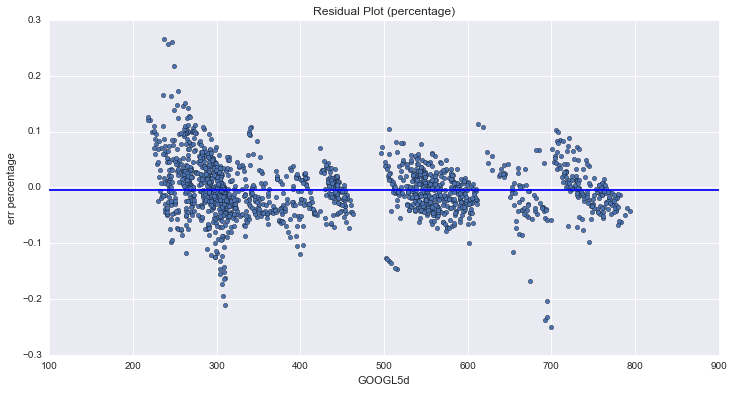

Err percentage mean: -0.418855417577%
Err percentage Std: 4.785762295%
Err percentage 95% CI: (-0.099903800075825389, 0.091526691724275383)


Smallest R^2:
[0.98385720841162816]


Smallest symbols:
['GOOGL']
0.983857208412
Outlier R^2:
[]


Outlier symbols:
[]
229.520201921 seconds elapsed for training/predicting/reporting.




In [118]:
# Supervised Learning
from sklearn import grid_search
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Find the n smallest elements in list
def more_min(arr, n_smallest=1):
    result_list = []

    if n_smallest > len(arr):
        raise ValueError("n_smallest greater than the length of the list!")
    else:
        arr_temp = list(arr)

        for i in range(n_smallest):
            result_list.append(np.min(arr_temp))
            arr_temp.remove(np.min(arr_temp))

        return result_list

# Find outliers
def get_outliers(arr):
    q75, q25 = np.percentile(arr, [75 ,25])
    iqr = q75 - q25
    
    thres = q25 - 1.5 * iqr
    print(thres)
    result = [u for u in arr if u < thres]
    
    return result

def make_predictions(data_X, data_y, date_range, estimator, window=105):
    pred_y_list = []
    drift_y_list = []
### Commented out code for monitoring feature importance of the RF
#     feature_importance_list = []
    
    for date in date_range:
        test_X = data_X.ix[date]
        (u,) = data_X.index.get_indexer_for([date])
        
        if u - window < 0:
            raise ValueError("Not enough training data!")
            
        train_X = data_X.iloc[(u - window):u - 5]
        train_y = data_y.iloc[(u - window):u - 5]

        estimator.fit(train_X, train_y)
        pred_y = estimator.predict(test_X.reshape(1, -1))
        pred_y_list.append(pred_y)
        
        drift_y = ((train_y.iloc[-1] - train_y.iloc[0]) / len(train_y)) * window * 1 + train_y.iloc[0]
        drift_y_list.append(drift_y)
        ## Create feature importance histogram
#         feature_importance_list.append(estimator.feature_importances_)
    
#     vif = [int(np.argmax(x)) for x in feature_importance_list]
#     vif = pd.DataFrame(vif)
#     d = np.diff(np.unique(vif)).min()
#     left_of_first_bin = vif.min() - float(d)/2
#     right_of_last_bin = vif.max() + float(d)/2
#     vif.plot.hist(alpha=0.5, bins=np.arange(left_of_first_bin, right_of_last_bin + d, d))
    return pred_y_list, drift_y_list

lr = RandomForestRegressor(criterion='mse', bootstrap=True)
reg = lr

r2_list = []
mse_list = []
min_list = []

# def train_and_report():
#     start_time = time.time()
    
#     for stock_name in stock_dict:
#         stock_dict[stock_name]['test_y'] = stock_dict[stock_name]['data_y'][121:]
#         stock_dict[stock_name]['pred_y'] = pd.Series(make_predictions(stock_dict[stock_name]['data_X'], stock_dict[stock_name]['data_y'], stock_dict[stock_name]['data_y'].index[121:], reg, 121))
#         stock_dict[stock_name]['pred_y'] = pd.DataFrame(stock_dict[stock_name]['pred_y'].tolist(), index=stock_dict[stock_name]['test_y'].index, columns=['Predict'])

#     for stock_name in stock_dict:
#         stock_dict[stock_name]['R2'] = r2_score(stock_dict[stock_name]['test_y'], stock_dict[stock_name]['pred_y'])
#         stock_dict[stock_name]['MSE'] = mean_squared_error(stock_dict[stock_name]['test_y'], stock_dict[stock_name]['pred_y'])
#         stock_dict[stock_name]['R2v2'] = r2_score(stock_dict[stock_name]['test_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)], stock_dict[stock_name]['pred_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)])
#         stock_dict[stock_name]['MSEv2'] = mean_squared_error(stock_dict[stock_name]['test_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)], stock_dict[stock_name]['pred_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)])

#     test_y = stock_dict[symbol]['test_y']
#     pred_y = stock_dict[symbol]['pred_y']

#     print(symbol)
#     print(reg.__class__.__name__)
#     print("R^2: {}".format(stock_dict[symbol]['R2']))
#     print("MSE: {}".format(stock_dict[symbol]['MSE']))
#     print("R^2 new range: {}".format(stock_dict[symbol]['R2v2']))
#     print("MSE new range: {}".format(stock_dict[symbol]['MSEv2']))

#     for stock_name in stock_dict:
#         stock_dict[stock_name]['dfResult'] = stock_dict[stock_name]['pred_y'].join(stock_dict[stock_name]['test_y'], )
#         stock_dict[stock_name]['dfResult'].columns = ['Predict', stock_dict[stock_name]['label_name']]

#     print(test_y.head())
#     print(pred_y.head())
#     dfResult2 = stock_dict[symbol]['dfResult']

#     # Stock price line chart
#     ax = dfResult2.plot(figsize=(12, 6), title=symbol)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Adj Close")
    
#     ax = dfResult2.ix[datetime(2015, 7, 1):datetime(2015, 9, 1)].plot(figsize=(12, 6), title=symbol)
#     ax.set_xlabel("Date")
#     ax.set_ylabel("Adj Close")
    
#     for stock_name in stock_dict:
#         stock_dict[stock_name]['diff'] = (stock_dict[stock_name]['dfResult']['Predict'] - stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]).to_frame()
#         stock_dict[stock_name]['diff'] = stock_dict[stock_name]['diff'].join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
#         stock_dict[stock_name]['diff'].columns = ['err', stock_dict[stock_name]['label_name']]

#     diff2 = stock_dict[symbol]['diff']

#     diff2.plot.scatter(x=label_name, y='err', title='Residual Plot', figsize=(12, 6))
#     plt.axhline(y=diff2['err'].mean())
#     plt.show()

#     print("Err mean: {}".format(diff2['err'].mean()))
#     print("Err Std: {}".format(diff2['err'].std()))

#     for stock_name in stock_dict:
#         stock_dict[stock_name]['diff_percent'] = ((stock_dict[stock_name]['dfResult']['Predict'] - stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]) / stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]).to_frame()
#         stock_dict[stock_name]['diff_percent'] = stock_dict[stock_name]['diff_percent'].join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
#         stock_dict[stock_name]['diff_percent'].columns = ['err percentage', stock_dict[stock_name]['label_name']]

#     diff3 = stock_dict[symbol]['diff_percent']    

#     diff3.plot.scatter(x=label_name, y='err percentage', title='Residual Plot (percentage)', figsize=(12, 6))
#     plt.axhline(y=diff3['err percentage'].mean())
#     plt.show()

#     print("Err percentage mean: {}%".format(diff3['err percentage'].mean() * 100))
#     print("Err percentage Std: {}%".format(diff3['err percentage'].std() * 100))
#     print("Err percentage 95% CI: {}".format((diff3['err percentage'].mean() - 2 * diff3['err percentage'].std(), diff3['err percentage'].mean() + 2 * diff3['err percentage'].std())))
#     print("\n")

#     # Get R2 and MSE list of all stocks
#     global r2_list
#     global mse_list
#     global min_list
    
#     r2_list = [stock_dict[x]['R2'] for x in stock_dict]
#     mse_list = [stock_dict[x]['MSE'] for x in stock_dict]
    
#     # Smallest R^2 list
#     min_list = more_min(r2_list, 1)
#     print("Smallest R^2:")
#     print(min_list)
#     print("\n")

#     # Get smallest R^2 symbols
#     min_id_list = [r2_list.index(x) for x in min_list]
#     min_symbol_list = [stock_dict.keys()[x] for x in min_id_list]
#     print("Smallest symbols:")
#     print(min_symbol_list)
    
#     # Outlier R^2 list
#     outlier_list = get_outliers(r2_list)
#     print("Outlier R^2:")
#     print(outlier_list)
#     print("\n")
    
#     # Get outlier R^2 symbols
#     outlier_id_list = [r2_list.index(x) for x in outlier_list]
#     outlier_symbol_list = [stock_dict.keys()[x] for x in outlier_id_list]
#     print("Outlier symbols:")
#     print(outlier_symbol_list)
    
#     print("{} seconds elapsed for training/predicting/reporting.".format(time.time() - start_time))
#     print("\n")

def report_multiple():
    print("R^2 (mean): {}%".format(np.mean(r2_list) * 100))
    print("R^2 (std): {}%".format(np.std(r2_list) * 100))
    print("R^2 (95% CI): {}".format((np.mean(r2_list) - 2 * np.std(r2_list), np.mean(r2_list) + 2 * np.std(r2_list))))

    # R2 Boxplot
    df_r2 = pd.DataFrame(r2_list)
    df_r2['Stock ID'] = df_r2.index
    df_r2.columns = ["R2", "Stock ID"]
    
    display(df_r2.describe())

    ax = sns.boxplot(y='R2', data=df_r2, orient='v')
    ax = sns.stripplot(y="R2", data=df_r2, jitter=0.05)

    #Evaluate the consistency of the residuals
    err_percent_mean_list = [stock_dict[x]['diff_percent']['err percentage'].mean() for x in stock_dict]
    err_percent_std_list = [stock_dict[x]['diff_percent']['err percentage'].std() for x in stock_dict]
    print("Err percentage mean (avg): {}".format(np.mean(err_percent_mean_list)))
    print("Err percentage Std (avg): {}".format(np.mean(err_percent_std_list)))
    print("Err percentage 95% CI (avg): {}".format((np.mean(err_percent_mean_list) - 2 * np.mean(err_percent_std_list), np.mean(err_percent_mean_list) + 2 * np.mean(err_percent_std_list))))
    
    # Err Mean Boxplot
    df_err = pd.DataFrame(err_percent_mean_list)
    df_err['Stock ID'] = df_err.index
    df_err.columns = ["Err Percentage Mean", "Stock ID"]

    display(df_err.describe())
    
    plt.figure()
    ax_err = sns.boxplot(y="Err Percentage Mean", data=df_err, orient='v', color='.45')
    ax_err = sns.stripplot(y="Err Percentage Mean", data=df_err, jitter=0.05)

    # Err Std Boxplot
    df_err_std = pd.DataFrame(err_percent_std_list)
    df_err_std['Stock ID'] = df_err_std.index
    df_err_std.columns = ["Err Percentage Std", "Stock ID"]

    display(df_err_std.describe())
    
    plt.figure()
    ax_err_std = sns.boxplot(y="Err Percentage Std", data=df_err_std, orient='v', color='.55')
    ax_err_std = sns.stripplot(y="Err Percentage Std", data=df_err_std, jitter=0.05)
    
# train_and_report()

start_time = time.time()
    
for stock_name in stock_dict:
    stock_dict[stock_name]['test_y'] = stock_dict[stock_name]['data_y'][121:]
    stock_dict[stock_name]['pred_y'] = pd.Series(make_predictions(stock_dict[stock_name]['data_X'], stock_dict[stock_name]['data_y'], stock_dict[stock_name]['data_y'].index[121:], reg, 121)[0])
    stock_dict[stock_name]['pred_y'] = pd.DataFrame(stock_dict[stock_name]['pred_y'].tolist(), index=stock_dict[stock_name]['test_y'].index, columns=['Predict'])
    stock_dict[stock_name]['drift_y'] = pd.Series(make_predictions(stock_dict[stock_name]['data_X'], stock_dict[stock_name]['data_y'], stock_dict[stock_name]['data_y'].index[121:], reg, 121)[1])
    stock_dict[stock_name]['drift_y'] = pd.DataFrame(stock_dict[stock_name]['drift_y'].tolist(), index=stock_dict[stock_name]['test_y'].index, columns=['Drift'])

for stock_name in stock_dict:
    stock_dict[stock_name]['R2'] = r2_score(stock_dict[stock_name]['test_y'], stock_dict[stock_name]['pred_y'])
    stock_dict[stock_name]['MSE'] = mean_squared_error(stock_dict[stock_name]['test_y'], stock_dict[stock_name]['pred_y'])
    stock_dict[stock_name]['R2v2'] = r2_score(stock_dict[stock_name]['test_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)], stock_dict[stock_name]['pred_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)])
    stock_dict[stock_name]['MSEv2'] = mean_squared_error(stock_dict[stock_name]['test_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)], stock_dict[stock_name]['pred_y'][datetime(2009, 12, 17):datetime(2016, 5, 27)])

test_y = stock_dict[symbol]['test_y']
pred_y = stock_dict[symbol]['pred_y']
drift_y = stock_dict[symbol]['drift_y']
print("Creating test_y: {}".format(len(test_y)))
print("Creating pred_y: {}".format(len(pred_y)))
print("Creating pred_y: {}".format(len(drift_y)))
print(test_y)
print(pred_y)
print(drift_y)

print(symbol)
print(reg.__class__.__name__)
print("R^2: {}".format(stock_dict[symbol]['R2']))
print("MSE: {}".format(stock_dict[symbol]['MSE']))
print("R^2 new range: {}".format(stock_dict[symbol]['R2v2']))
print("MSE new range: {}".format(stock_dict[symbol]['MSEv2']))

for stock_name in stock_dict:
    stock_dict[stock_name]['dfResult'] = stock_dict[stock_name]['pred_y'].join(stock_dict[stock_name]['test_y'], )
    stock_dict[stock_name]['dfResult'].columns = ['Predict', stock_dict[stock_name]['label_name']]

print(test_y.head())
print(pred_y.head())
dfResult2 = stock_dict[symbol]['dfResult']

# Stock price line chart
ax = dfResult2.plot(figsize=(12, 6), title=symbol)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")

ax = dfResult2.ix[datetime(2015, 7, 1):datetime(2015, 9, 1)].plot(figsize=(12, 6), title=symbol)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")

for stock_name in stock_dict:
    stock_dict[stock_name]['diff'] = (stock_dict[stock_name]['dfResult']['Predict'] - stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]).to_frame()
    stock_dict[stock_name]['diff'] = stock_dict[stock_name]['diff'].join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
    stock_dict[stock_name]['diff'].columns = ['err', stock_dict[stock_name]['label_name']]

diff2 = stock_dict[symbol]['diff']

diff2.plot.scatter(x=label_name, y='err', title='Residual Plot', figsize=(12, 6))
plt.axhline(y=diff2['err'].mean())
plt.show()

print("Err mean: {}".format(diff2['err'].mean()))
print("Err Std: {}".format(diff2['err'].std()))

for stock_name in stock_dict:
    stock_dict[stock_name]['diff_percent'] = ((stock_dict[stock_name]['dfResult']['Predict'] - stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]) / stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']]).to_frame()
    stock_dict[stock_name]['diff_percent'] = stock_dict[stock_name]['diff_percent'].join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
    stock_dict[stock_name]['diff_percent'].columns = ['err percentage', stock_dict[stock_name]['label_name']]

diff3 = stock_dict[symbol]['diff_percent']    

diff3.plot.scatter(x=label_name, y='err percentage', title='Residual Plot (percentage)', figsize=(12, 6))
plt.axhline(y=diff3['err percentage'].mean())
plt.show()

print("Err percentage mean: {}%".format(diff3['err percentage'].mean() * 100))
print("Err percentage Std: {}%".format(diff3['err percentage'].std() * 100))
print("Err percentage 95% CI: {}".format((diff3['err percentage'].mean() - 2 * diff3['err percentage'].std(), diff3['err percentage'].mean() + 2 * diff3['err percentage'].std())))
print("\n")

# Get R2 and MSE list of all stocks
global r2_list
global mse_list
global min_list

r2_list = [stock_dict[x]['R2'] for x in stock_dict]
mse_list = [stock_dict[x]['MSE'] for x in stock_dict]

# Smallest R^2 list
min_list = more_min(r2_list, 1)
print("Smallest R^2:")
print(min_list)
print("\n")

# Get smallest R^2 symbols
min_id_list = [r2_list.index(x) for x in min_list]
min_symbol_list = [stock_dict.keys()[x] for x in min_id_list]
print("Smallest symbols:")
print(min_symbol_list)

# Outlier R^2 list
outlier_list = get_outliers(r2_list)
print("Outlier R^2:")
print(outlier_list)
print("\n")

# Get outlier R^2 symbols
outlier_id_list = [r2_list.index(x) for x in outlier_list]
outlier_symbol_list = [stock_dict.keys()[x] for x in outlier_id_list]
print("Outlier symbols:")
print(outlier_symbol_list)

print("{} seconds elapsed for training/predicting/reporting.".format(time.time() - start_time))
print("\n")

#### Checking against our benchmark

In [119]:
# Inverse sign log transform
def inv_sign_log(df):
    inv_df = np.sign(df) * (np.exp(np.abs(df)) - 1)
    return inv_df

for stock_name in stock_dict:
    stock_dict[stock_name]['original_SMA'] = inv_sign_log(stock_dict[stock_name]['data_X'][symbol + '_SMA'])

sma_y = stock_dict[symbol]['original_SMA'][test_y.index]
naive_y = stock_dict[symbol]['original_data_y'][test_y.index]
drift_y = drift_y

# print(stock_dict['GOOGL']['original_SMA'])
print(len(test_y))
print(len(sma_y))
print(len(naive_y))
print(len(drift_y))
print(test_y.head())
print(sma_y.head())
print(naive_y.head())
print(drift_y.head())


1658
1658
1658
1658
2009-11-18    293.163181
2009-11-19    290.170170
2009-11-20    291.791782
2009-11-23    295.230228
2009-11-24    294.049046
Name: GOOGL, dtype: float64
2009-11-18    241.124026
2009-11-19    241.843279
2009-11-20    242.566402
2009-11-23    243.358415
2009-11-24    244.217391
Name: GOOGL_SMA, dtype: float64
2009-11-18    288.613621
2009-11-19    286.781772
2009-11-20    285.265262
2009-11-23    291.466465
2009-11-24    291.836826
Name: GOOGL, dtype: float64
                 Drift
2009-11-18  291.906947
2009-11-19  291.588148
2009-11-20  289.745295
2009-11-23  288.228570
2009-11-24  294.774730


Drift R^2: 0.987859843147
Drift MSE: 320.455144024


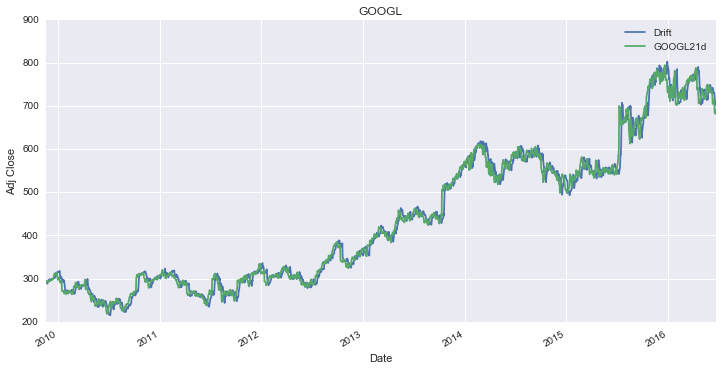

In [120]:
drift_test_df = drift_y.join(test_y)
drift_test_df.columns = ['Drift', 'GOOGL21d']

print("Drift R^2: {}".format(r2_score(drift_test_df['GOOGL21d'], drift_test_df['Drift'])))
print("Drift MSE: {}".format(mean_squared_error(drift_test_df['GOOGL21d'], drift_test_df['Drift'])))

ax = drift_test_df.plot(figsize=(12, 6), title=symbol)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()

SMA R^2: 0.940567690245
SMA MSE: 1568.79269462


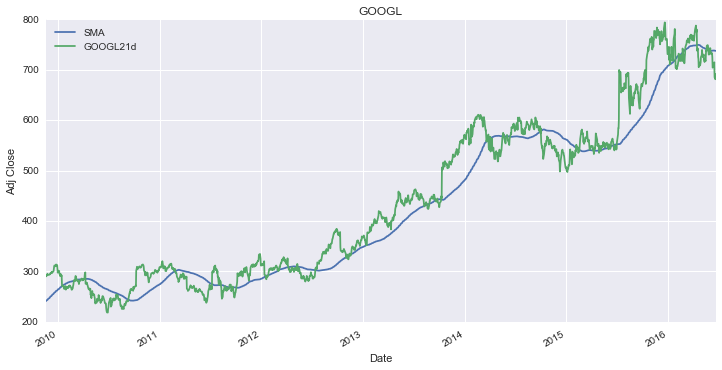

In [121]:
stock_dict[symbol]['sma_y'] = pd.Series(sma_y)
stock_dict[symbol]['sma_y'] = pd.DataFrame(stock_dict[symbol]['sma_y'].tolist(), index=stock_dict[symbol]['test_y'].index, columns=['SMA'])

sma_y = stock_dict[symbol]['sma_y']

sma_test_df = sma_y.join(test_y)
sma_test_df.columns = ['SMA', 'GOOGL21d']

print("SMA R^2: {}".format(r2_score(sma_test_df['GOOGL21d'], sma_test_df['SMA'])))
print("SMA MSE: {}".format(mean_squared_error(sma_test_df['GOOGL21d'], sma_test_df['SMA'])))

ax = sma_test_df.plot(figsize=(12, 6), title=symbol)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()

Naive R^2: 0.989881991348
Naive MSE: 267.077926528


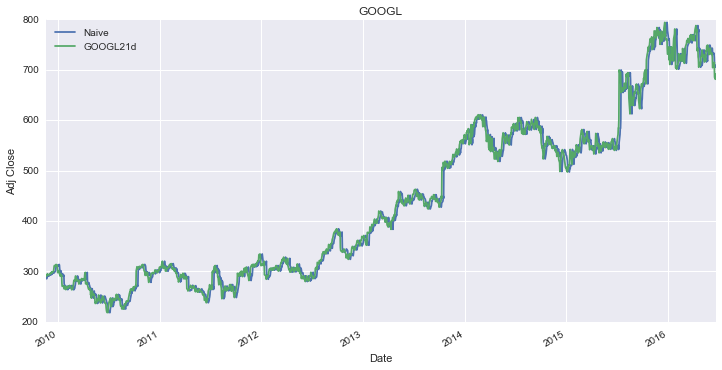

In [122]:
stock_dict[symbol]['naive_y'] = pd.Series(naive_y)
stock_dict[symbol]['naive_y'] = pd.DataFrame(stock_dict[symbol]['naive_y'].tolist(), index=stock_dict[symbol]['test_y'].index, columns=['Naive'])

naive_y = stock_dict[symbol]['naive_y']

naive_test_df = naive_y.join(test_y)
naive_test_df.columns = ['Naive', 'GOOGL21d']

print("Naive R^2: {}".format(r2_score(naive_test_df['GOOGL21d'], naive_test_df['Naive'])))
print("Naive MSE: {}".format(mean_squared_error(naive_test_df['GOOGL21d'], naive_test_df['Naive'])))

ax = naive_test_df.plot(figsize=(12, 6), title=symbol)
ax.set_xlabel("Date")
ax.set_ylabel("Adj Close")
plt.show()

### Refinement
#### Grid Search and Cross Validation
As discussed earlier, there are couple of parameters we can tune to improve the random forest algorithm. In this section we will try to improve our model by focusing on the following aspects:

1. Try different number of trees
2. Try different number of max features to consider when building trees

According to *How Many Trees in a Random Forest?* (https://www.researchgate.net/publication/230766603_How_Many_Trees_in_a_Random_Forest), the goldilocks lies somewhere bewteen 64 to 128 trees. Any futher number of trees only adds computational cost. We shall try some numbers in that zone.

As to the max features, we shall try to grid search through the following methods:

1. Square root of N (N being number of features)
2. Log2 of N
3. N

#### Validity test
Due to the lack of resource, we won't be able to optimize for all the stocks. As a proof of concept, we will use one to make our point.

In [15]:
GOOGL = stock_dict[symbol]['original_data_y']
display(GOOGL)

2009-01-02    160.820818
2009-01-05    164.189196
2009-01-06    167.197207
2009-01-07    161.166170
2009-01-08    162.757754
2009-01-09    157.692690
2009-01-12    156.501497
2009-01-13    157.317324
2009-01-14    150.635637
2009-01-15    149.644640
2009-01-16    149.984987
2009-01-20    141.516512
2009-01-21    151.691698
2009-01-22    153.403399
2009-01-23    162.512514
2009-01-26    162.097094
2009-01-27    165.905901
2009-01-28    174.509508
2009-01-29    171.831835
2009-01-30    169.434435
2009-02-02    170.455462
2009-02-03    170.395403
2009-02-04    171.671679
2009-02-05    177.037035
2009-02-06    185.825823
2009-02-09    189.574572
2009-02-10    179.434435
2009-02-11    179.199206
2009-02-12    181.706713
2009-02-13    179.019015
                 ...    
2016-05-17    720.190002
2016-05-18    721.780029
2016-05-19    715.309998
2016-05-20    721.710022
2016-05-23    717.250000
2016-05-24    733.030029
2016-05-25    738.099976
2016-05-26    736.929993
2016-05-27    747.599976


In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=100, center=False).mean()
    rolstd = timeseries.rolling(window=100, center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.figure(figsize=(12,6))
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

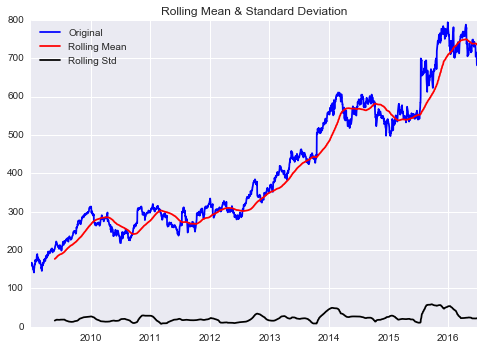

Results of Dickey-Fuller Test:
Test Statistic                   -0.744032
p-value                           0.835012
#Lags Used                        0.000000
Number of Observations Used    1884.000000
Critical Value (5%)              -2.863075
Critical Value (1%)              -3.433826
Critical Value (10%)             -2.567587
dtype: float64


In [17]:
test_stationarity(GOOGL)

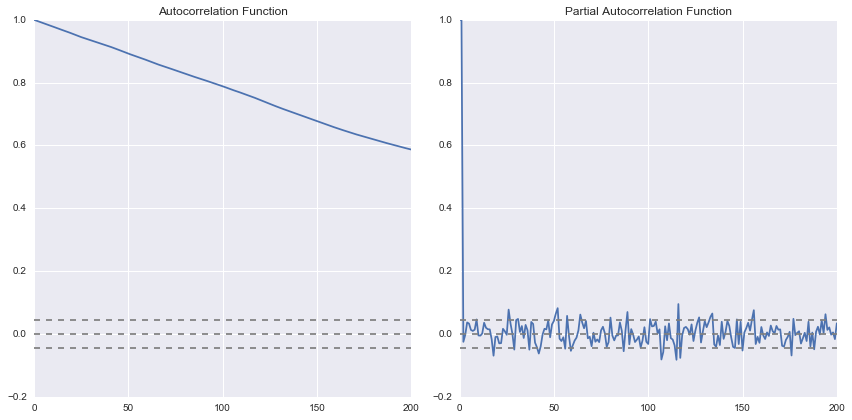

In [18]:
from statsmodels.tsa.stattools import acf, pacf

def plot_acf_pacf(data, nlags=21):
    lag_acf = acf(data, nlags=nlags)
    lag_pacf = pacf(data, nlags=nlags, method='ols')

    f, ax = plt.subplots(figsize=(12, 6))
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
    
plot_acf_pacf(GOOGL, 200)

In [19]:
GOOGL_log = np.sign(GOOGL) * np.log(abs(GOOGL) + 1)
GOOGL_log_diff = GOOGL_log - GOOGL_log.shift()
print(len(GOOGL_log))
print(len(GOOGL_log_diff))
print(GOOGL_log.head())
print(GOOGL_log_diff.head())

1885
1885
2009-01-02    5.086490
2009-01-05    5.107091
2009-01-06    5.125137
2009-01-07    5.088622
2009-01-08    5.098388
Name: GOOGL, dtype: float64
2009-01-02         NaN
2009-01-05    0.020602
2009-01-06    0.018046
2009-01-07   -0.036516
2009-01-08    0.009767
Name: GOOGL, dtype: float64


1885
2009-01-02         NaN
2009-01-05    0.020602
2009-01-06    0.018046
2009-01-07   -0.036516
2009-01-08    0.009767
Name: GOOGL, dtype: float64


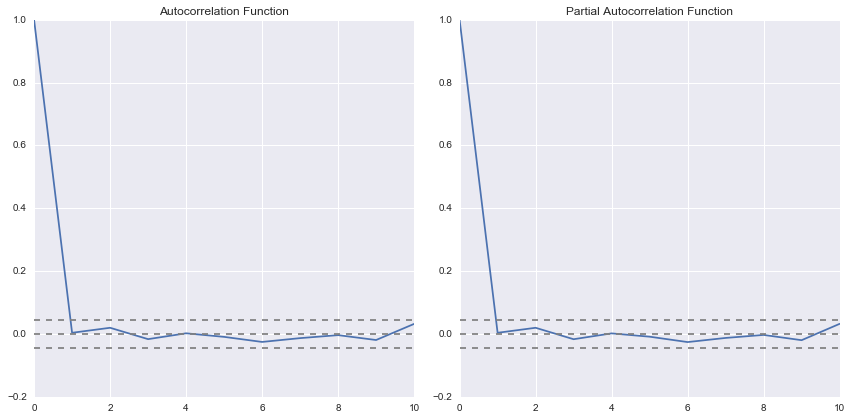

In [20]:
print(len(GOOGL_log_diff))
print(GOOGL_log_diff.head())
plot_acf_pacf(GOOGL_log_diff.dropna(), 10)

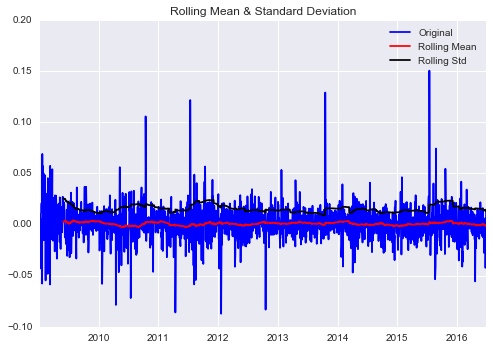

Results of Dickey-Fuller Test:
Test Statistic                  -43.215692
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1883.000000
Critical Value (5%)              -2.863076
Critical Value (1%)              -3.433828
Critical Value (10%)             -2.567588
dtype: float64


In [21]:
test_stationarity(GOOGL_log_diff.dropna())

In [22]:
# GOOGL_log_diff2.dropna(inplace=True)
# print(len(GOOGL_log_diff2))
# print(GOOGL_log_diff2.head())

GOOGL_log_diff.dropna(inplace=True)
print(len(GOOGL_log_diff))
print(GOOGL_log_diff.head())


1884
2009-01-05    0.020602
2009-01-06    0.018046
2009-01-07   -0.036516
2009-01-08    0.009767
2009-01-09   -0.031419
Name: GOOGL, dtype: float64


In [23]:
from statsmodels.tsa.arima_model import ARMA
import warnings

date_length = len(GOOGL_log_diff)
pred_ARMA_list = []

for i in range(date_length - 121 + 1):
    model = ARMA(GOOGL_log_diff.ix[i:i+100], order=(0, 0))
    results_AR = model.fit(disp=-1)
    warnings.filterwarnings("ignore")
    pred_ARMA = results_AR.predict(start=len(results_AR.fittedvalues) - 1, end=len(results_AR.fittedvalues) + 20, dynamic=True)
    pred_ARMA_list.append(pred_ARMA.iloc[-1])

print(len(GOOGL_log_diff))
print(len(pred_ARMA_list))

########

# date_length2 = len(GOOGL_log_diff2)
# pred_ARMA_list2 = []

# for i in range(date_length2 - 121 + 1):
#     model = ARMA(GOOGL_log_diff2.ix[i:i+100], order=(0, 0))
#     results_AR = model.fit(disp=-1)
    
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore")
#         pred_ARMA = results_AR.predict(start=len(results_AR.fittedvalues) - 1, end=len(results_AR.fittedvalues) + 20)
#     pred_ARMA_list2.append(pred_ARMA.iloc[-1])

# print(len(GOOGL_log_diff2))
# print(len(pred_ARMA_list2))

########

# date_length = len(GOOGL_log_diff2)
# pred_ARIMA_list = []

# for i in range(date_length - 121 + 1):
#     model = ARIMA(GOOGL_log.ix[i:i+100], order=(0, 2, 1))
#     results_AR = model.fit(disp=-1)
#     warnings.filterwarnings("ignore")
#     pred_ARIMA = results_AR.predict(start=len(results_AR.fittedvalues) - 1, end=len(results_AR.fittedvalues) + 20)
#     pred_ARIMA_list.append(pred_ARIMA.iloc[-1])

# print(len(GOOGL_log))
# print(len(pred_ARIMA_list))


1884
1764


2009-06-26    0.002434
2009-06-29    0.002392
2009-06-30    0.002431
2009-07-01    0.002839
2009-07-02    0.002817
dtype: float64
2016-06-22   -0.001015
2016-06-23   -0.000751
2016-06-24   -0.000526
2016-06-27   -0.000300
2016-06-28   -0.000184
dtype: float64
2009-06-26    0.022602
2009-06-29   -0.002765
2009-06-30   -0.006002
2009-07-01   -0.006157
2009-07-02   -0.025258
Name: GOOGL, dtype: float64
2016-06-22    0.002237
2016-06-23    0.006165
2016-06-24   -0.042329
2016-06-27   -0.005934
2016-06-28    0.014727
Name: GOOGL, dtype: float64


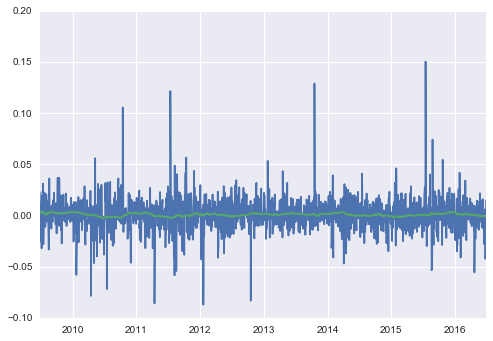

In [24]:
predictions_ARMA_log_diff = pd.Series(pred_ARMA_list, index=GOOGL_log_diff.index[120:], copy=True)
print(predictions_ARMA_log_diff.head())
print(predictions_ARMA_log_diff.tail())
print(GOOGL_log_diff.iloc[120:].head())
print(GOOGL_log_diff.iloc[120:].tail())

plt.plot(GOOGL_log_diff.iloc[120:])
plt.plot(predictions_ARMA_log_diff)

##########

# predictions_ARMA_log_diff2 = pd.Series(pred_ARMA_list2, index=GOOGL_log_diff.index[121:], copy=True)
# # print(predictions_ARIMA_log_diff.head(50))
# # print(GOOGL_log_diff.iloc[120:].head(50))

# # plt.plot(GOOGL_log_diff2.iloc[120:][datetime(2011, 4, 1):datetime(2011, 6, 31)])
# # plt.plot(predictions_ARMA_log_diff2[datetime(2011, 4, 1):datetime(2012, 6, 31)])

# plt.plot(GOOGL_log_diff2.iloc[121:])
# plt.plot(predictions_ARMA_log_diff2)

##########

# predictions_ARIMA_log_diff2 = pd.Series(pred_ARIMA_list, index=GOOGL_log_diff2.index[120:], copy=True)
# print(predictions_ARIMA_log_diff.head(50))
# print(GOOGL_log_diff.iloc[120:].head(50))

# plt.plot(GOOGL_log_diff2.iloc[120:][datetime(2011, 4, 1):datetime(2011, 6, 31)])
# plt.plot(predictions_ARMA_log_diff2[datetime(2011, 4, 1):datetime(2012, 6, 31)])


# plt.plot(GOOGL_log_diff2.iloc[121:])
# plt.plot(predictions_ARIMA_log_diff2)

# print(GOOGL_log.head())
# print(pred_ARIMA_list.head())


               GOOGL      ARMA
2009-01-05  0.020602  0.020602
2009-01-06  0.018046  0.018046
2009-01-07 -0.036516 -0.036516
2009-01-08  0.009767  0.009767
2009-01-09 -0.031419 -0.031419
2009-01-12 -0.007535 -0.007535
2009-01-13  0.005166  0.005166
2009-01-14 -0.043121 -0.043121
2009-01-15 -0.006557 -0.006557
2009-01-16  0.002257  0.002257
2009-01-20 -0.057723 -0.057723
2009-01-21  0.068963  0.068963
2009-01-22  0.011148  0.011148
2009-01-23  0.057321  0.057321
2009-01-26 -0.002544 -0.002544
2009-01-27  0.023084  0.023084
2009-01-28  0.050263  0.050263
2009-01-29 -0.015374 -0.015374
2009-01-30 -0.013968 -0.013968
2009-02-02  0.005973  0.005973
2009-02-03 -0.000350 -0.000350
2009-02-04  0.007419  0.007419
2009-02-05  0.030600  0.030600
2009-02-06  0.048185  0.048185
2009-02-09  0.019867  0.019867
2009-02-10 -0.054676 -0.054676
2009-02-11 -0.001305 -0.001305
2009-02-12  0.013819  0.013819
2009-02-13 -0.014820 -0.014820
2009-02-17 -0.042657 -0.042657
...              ...       ...
2016-05-

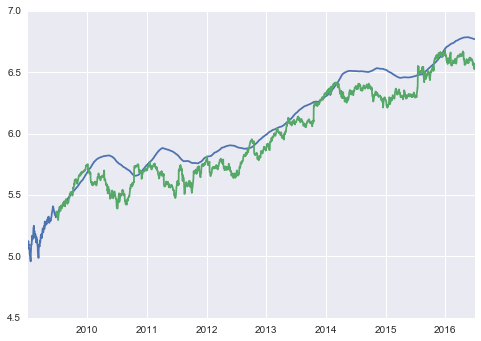

In [25]:
GOOGL_log_diff_df = GOOGL_log_diff.to_frame()
# print(GOOGL_log_diff_df)
GOOGL_log_diff_df['ARMA'] = predictions_ARMA_log_diff
# print(GOOGL_log_diff_df)
# print(GOOGL_log_diff_df['ARIMA'].isnull().sum())

GOOGL_log_diff_df['ARMA'].fillna(GOOGL_log_diff_df['GOOGL'], inplace=True)

print(GOOGL_log_diff_df)

predictions_ARMA_log_diff = GOOGL_log_diff_df['ARMA']

GOOGL_log_addback = GOOGL_log_diff_df['GOOGL'].cumsum() + GOOGL_log.ix[0]
predictions_ARMA_log = predictions_ARMA_log_diff.cumsum() + GOOGL_log.ix[0]
print(GOOGL_log_addback.head())
print(GOOGL_log[1:].head())
print(predictions_ARMA_log.head())

print(GOOGL_log_addback.tail())
print(GOOGL_log[1:].tail())
print(predictions_ARMA_log.tail())

# predictions_ARMA_log_diff_cumsum = predictions_ARMA_log_diff.cumsum()
# print(predictions_ARMA_log_diff_cumsum.head())
# print(predictions_ARMA_log_diff_cumsum.tail())

# predictions_ARMA_log = predictions_ARMA_log_diff_cumsum + GOOGL_log.ix[0]

# print(predictions_ARMA_log.head())
# print(predictions_ARMA_log.tail())
# print(len(predictions_ARMA_log))

plt.plot(predictions_ARMA_log)
plt.plot(GOOGL_log.iloc[120:])

############
# print(GOOGL_log_diff2.iloc[120:].head())
# print(GOOGL_log_diff2.iloc[120:].tail())

# print(predictions_ARMA_log_diff2.head())
# print(predictions_ARMA_log_diff2.tail())

# print(GOOGL_log_diff2.iloc[120:].cumsum().head())
# print(GOOGL_log_diff2.iloc[120:].cumsum().tail())
# predictions_ARMA_log_diff2_cumsum = predictions_ARMA_log_diff2.cumsum()
# print(predictions_ARMA_log_diff2_cumsum.head())
# print(predictions_ARMA_log_diff2_cumsum.tail())

# print((GOOGL_log_diff2.iloc[120:].cumsum() + GOOGL_log_diff.ix[0]).head())
# print((GOOGL_log_diff2.iloc[120:].cumsum() + GOOGL_log_diff.ix[0]).tail())
# predictions_ARMA_log_diff1 = predictions_ARMA_log_diff2_cumsum + GOOGL_log_diff.ix[0]
# print(predictions_ARMA_log_diff1.head())
# print(predictions_ARMA_log_diff1.tail())
# print(len(GOOGL_log_diff2))
# print(len(predictions_ARIMA_log_diff2))

# print(type(GOOGL_log_diff2))
# print(type(predictions_ARIMA_log_diff2))

# GOOGL_log_diff2_df = GOOGL_log_diff2.to_frame()
# print(GOOGL_log_diff2_df)
# GOOGL_log_diff2_df['ARIMA'] = predictions_ARIMA_log_diff2
# print(GOOGL_log_diff2_df)
# # print(GOOGL_log_diff2_df['ARIMA'].isnull())

# GOOGL_log_diff2_df['ARIMA'].fillna(GOOGL_log_diff2_df['GOOGL'], inplace=True)

# print(GOOGL_log_diff2_df)
# predictions_ARIMA_log_diff2 = GOOGL_log_diff2_df['ARIMA']

# # print(((GOOGL_log_diff2.cumsum() - GOOGL_log.ix[0] + GOOGL_log.ix[1]).cumsum() + GOOGL_log.ix[1]).head())
# # print(((GOOGL_log_diff2.cumsum() - GOOGL_log.ix[0] + GOOGL_log.ix[1]).cumsum() + GOOGL_log.ix[1]).tail())

# # print(GOOGL_log[2:].head())
# # print(GOOGL_log[2:].tail())

# GOOGL_log_diff1_addback = GOOGL_log_diff2.cumsum() - GOOGL_log.ix[0] + GOOGL_log.ix[1]
# predictions_ARIMA_log_diff1_addback = predictions_ARIMA_log_diff2.cumsum() - GOOGL_log.ix[0] + GOOGL_log.ix[1]

# print(GOOGL_log_diff1_addback.head())
# print(GOOGL_log_diff1_addback.tail())
# print(predictions_ARIMA_log_diff1_addback.head())
# print(predictions_ARIMA_log_diff1_addback.tail())

# predictions_ARIMA_log_diff1_addback_adj = predictions_ARIMA_log_diff1_addback - 0.0198777033263

# predictions_ARIMA_log = (predictions_ARIMA_log_diff1_addback_adj).cumsum() + GOOGL_log.ix[1]
# print(predictions_ARIMA_log.head())
# print(predictions_ARIMA_log.tail())

# predictions_ARMA_log_diff1_cumsum = predictions_ARMA_log_diff1.cumsum()
# print(predictions_ARMA_log_diff1_cumsum.head())
# print(predictions_ARMA_log_diff1_cumsum.tail())

# predictions_ARMA_log = predictions_ARMA_log_diff1_cumsum + GOOGL_log_diff.ix[0] + GOOGL_log.ix[0]
# print(predictions_ARMA_log_diff1_cumsum.head())
# print(predictions_ARMA_log_diff1_cumsum.tail())

# print(predictions_ARMA_log.head())
# print(predictions_ARMA_log.tail())
# print(len(predictions_ARMA_log))

# plt.plot(GOOGL_log_diff1_addback.iloc[120:])
# plt.plot(predictions_ARIMA_log_diff1_addback)

# print(predictions_ARIMA_log_diff1_addback.mean())
# print(GOOGL_log_diff1_addback.iloc[120:].mean())

# plt.plot(np.exp(GOOGL_log.ioc[120:]))
# plt.plot(GOOGL_log.iloc[120:])
# plt.plot(predictions_ARIMA_log)

# plt.plot(predictions_ARIMA_log)
# plt.plot(GOOGL_log.iloc[120:])


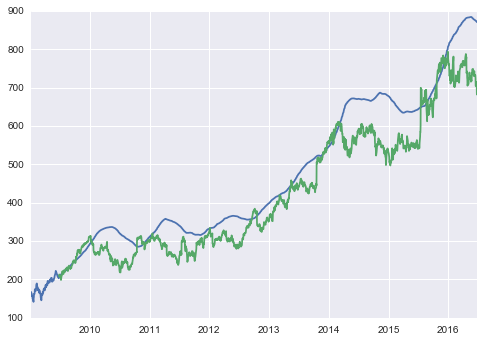

In [26]:
predictions_ARMA = np.sign(predictions_ARMA_log) * (np.exp(np.abs(predictions_ARMA_log)) - 1)

plt.plot(predictions_ARMA)
plt.plot(GOOGL.iloc[120:])

In [27]:
from sklearn.metrics import r2_score, mean_squared_error

# print(GOOGL21d_log.head())
# print(predictions_ARIMA_log.isnull().sum())
print(r2_score(GOOGL_log[1:], predictions_ARMA_log))


0.876511175497


0.842711455988
                Residual       GOOGL
2009-01-05  2.842171e-14  164.189196
2009-01-06  0.000000e+00  167.197207
2009-01-07  0.000000e+00  161.166170
2009-01-08  0.000000e+00  162.757754
2009-01-09  2.842171e-14  157.692690
2009-01-12 -5.684342e-14  156.501497
2009-01-13  2.842171e-14  157.317324
2009-01-14 -2.842171e-14  150.635637
2009-01-15 -2.842171e-14  149.644640
2009-01-16  5.684342e-14  149.984987
2009-01-20  2.842171e-14  141.516512
2009-01-21  0.000000e+00  151.691698
2009-01-22  0.000000e+00  153.403399
2009-01-23  2.842171e-14  162.512514
2009-01-26  5.684342e-14  162.097094
2009-01-27  2.842171e-14  165.905901
2009-01-28 -5.684342e-14  174.509508
2009-01-29  0.000000e+00  171.831835
2009-01-30 -5.684342e-14  169.434435
2009-02-02 -2.842171e-14  170.455462
2009-02-03 -5.684342e-14  170.395403
2009-02-04  5.684342e-14  171.671679
2009-02-05 -2.842171e-14  177.037035
2009-02-06 -5.684342e-14  185.825823
2009-02-09  2.842171e-14  189.574572
2009-02-10  2.842171e-1

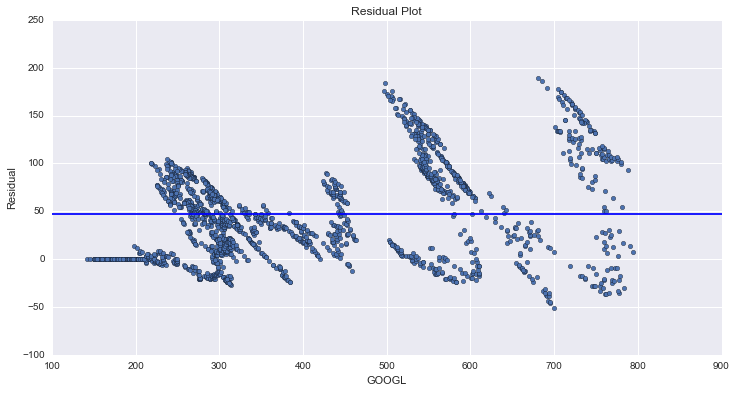

In [28]:
predictions_ARMA = np.sign(predictions_ARMA_log) * (np.exp(np.abs(predictions_ARMA_log)) - 1)

# plt.plot(predictions_ARMA)
# plt.plot(GOOGL.iloc[120:])

print(r2_score(GOOGL[1:], predictions_ARMA))


res = (predictions_ARMA - GOOGL.iloc[1:]).to_frame()
# res = res.join(stock_dict[stock_name]['dfResult'][stock_dict[stock_name]['label_name']])
res.columns = ['Residual']
# res = res.join(GOOGL[1:].index)
res = res.join(GOOGL[1:])
print(res)

# plt.plot_date(res.index, res['Residual'])
res.plot.scatter(x='GOOGL', y='Residual', title='Residual Plot', figsize=(12, 6))
plt.axhline(y=res['Residual'].mean())
plt.show()


In [29]:
# print(predictions_ARMA_log.head())
# print(predictions_ARMA_log.tail())

# print(predictions_ARMA_log.shift(-21).head())
# print(predictions_ARMA_log.shift(-21).tail())

data_X['ARMA21d'] = predictions_ARMA_log.shift(-21)
data_X['Naive21d'] = sign_log(naive_y)
data_X['SMA21d'] = sign_log(sma_y)
data_X['Drift21d'] = sign_log(drift_y)
# data_X['ARMA_EMA'] = data_X['ARMA21d'] + data_X[symbol + '_EMA']

print(data_X.head())
print(data_X.tail())

# data_X.dropna(inplace=True)

# print(data_X.head())
# print(data_X.tail())

            GOOGL_Vol    STLFSI  GOOGL_Std63d  GOOGL_Beta  GOOGL_EMA  \
2009-05-29  15.481537  0.938052      0.004201    0.982632   5.346268   
2009-06-01  15.708336  0.938052      0.004127    0.952905   5.368279   
2009-06-02  15.472195  0.938052      0.004121    0.950854   5.372564   
2009-06-03  15.769743  0.938052      0.004075    0.991606   5.380087   
2009-06-04  15.799116  0.938052      0.003913    0.969578   5.399792   

            GOOGL_MMA  GOOGL_SMA  GOOGL_SMA_Momentum  GOOGL_Vol_Momentum  \
2009-05-29   5.161414   5.181363            0.259779           -0.781512   
2009-06-01   5.163483   5.183949            0.261188           22.906757   
2009-06-02   5.165574   5.186398            0.247427          -23.850313   
2009-06-03   5.167719   5.189284            0.291465           30.052397   
2009-06-04   5.170040   5.192268            0.301404            2.966613   

            GOOGL_Vol_M1  GOOGL_Vol_M2  GOOGL_Vol_M3  GOOGL_SR63d  \
2009-05-29           0.0           0.0   

In [30]:
# print(data_X.isnull().sum())
# print(data_y.isnull().sum())

print(len(data_X))
print(len(data_y))

print(data_X.head())
print(data_X.tail())
print(data_y.head())
print(data_y.tail())

data_X.dropna(inplace=True)
data_y = data_y[data_X.index]

print(len(data_X))
print(len(data_y))

try:
    data_X.drop([symbol + '_SMA', symbol + '_MMA', symbol + '_Vol_M1', symbol + '_Vol_M2', symbol + '_Vol_M3'], axis=1, inplace=True)
except ValueError:
    print('OK, seems like these columns are already gone...')

print(data_X.columns)

1763
1763
            GOOGL_Vol    STLFSI  GOOGL_Std63d  GOOGL_Beta  GOOGL_EMA  \
2009-05-29  15.481537  0.938052      0.004201    0.982632   5.346268   
2009-06-01  15.708336  0.938052      0.004127    0.952905   5.368279   
2009-06-02  15.472195  0.938052      0.004121    0.950854   5.372564   
2009-06-03  15.769743  0.938052      0.004075    0.991606   5.380087   
2009-06-04  15.799116  0.938052      0.003913    0.969578   5.399792   

            GOOGL_MMA  GOOGL_SMA  GOOGL_SMA_Momentum  GOOGL_Vol_Momentum  \
2009-05-29   5.161414   5.181363            0.259779           -0.781512   
2009-06-01   5.163483   5.183949            0.261188           22.906757   
2009-06-02   5.165574   5.186398            0.247427          -23.850313   
2009-06-03   5.167719   5.189284            0.291465           30.052397   
2009-06-04   5.170040   5.192268            0.301404            2.966613   

            GOOGL_Vol_M1  GOOGL_Vol_M2  GOOGL_Vol_M3  GOOGL_SR63d  \
2009-05-29           0.0       

In [31]:
def make_predictions(data_X, data_y, date_range, estimator, window=121):
    pred_y_list = []
### Commented out code for monitoring feature importance of the RF
#     feature_importance_list = []
    
    for date in date_range:
        test_X = data_X.ix[date]
        (u,) = data_X.index.get_indexer_for([date])
        
#         print("u: {}".format(u))
#         print("windows: {}".format(window))
        if u - window < 0:
            raise ValueError("Not enough training data!")
            
        train_X = data_X.iloc[(u - window):u - 21]
        train_y = data_y.iloc[(u - window):u - 21]

        estimator.fit(train_X, train_y)
        pred_y = estimator.predict(test_X.reshape(1, -1))
        pred_y_list.append(pred_y)
        
        ## Create feature importance histogram
#         feature_importance_list.append(estimator.feature_importances_)
    
#     vif = [int(np.argmax(x)) for x in feature_importance_list]
#     vif = pd.DataFrame(vif)
#     d = np.diff(np.unique(vif)).min()
#     left_of_first_bin = vif.min() - float(d)/2
#     right_of_last_bin = vif.max() + float(d)/2
#     vif.plot.hist(alpha=0.5, bins=np.arange(left_of_first_bin, right_of_last_bin + d, d))
    return pred_y_list

lr = RandomForestRegressor(n_estimators=10, criterion='mse', max_features='log2', bootstrap=True)
reg = lr

test_y = data_y[121:]
pred_y_series = pd.Series(make_predictions(data_X, data_y, data_y.index[121:], reg, window=121))
pred_y = pd.DataFrame(pred_y_series.tolist(), index=test_y.index, columns=['Predict'])

print(test_y)
print(pred_y)

# print(data_X.isnull().sum())

2010-05-14    249.244251
2010-05-17    250.885883
2010-05-18    250.290286
2010-05-19    250.265262
2010-05-20    244.524524
2010-05-21    243.368366
2010-05-24    241.266269
2010-05-25    237.787784
2010-05-26    236.576587
2010-05-27    236.276279
2010-05-28    227.357364
2010-06-01    222.697696
2010-06-02    219.964969
2010-06-03    218.493503
2010-06-04    218.253253
2010-06-07    225.325336
2010-06-08    228.508517
2010-06-09    233.978976
2010-06-10    238.153156
2010-06-11    244.844852
2010-06-14    245.915912
2010-06-15    247.257266
2010-06-16    230.035037
2010-06-17    233.323321
2010-06-18    241.036044
2010-06-21    238.988986
2010-06-22    242.647647
2010-06-23    245.275272
2010-06-24    244.729739
2010-06-25    246.561557
                 ...    
2016-04-18    720.190002
2016-04-19    721.780029
2016-04-20    715.309998
2016-04-21    721.710022
2016-04-22    717.250000
2016-04-25    733.030029
2016-04-26    738.099976
2016-04-27    736.929993
2016-04-28    747.599976


R2: 0.94991521874
MSE: 1307.81274391
               Predict       GOOGL
2010-05-14  286.726731  249.244251
2010-05-17  286.091090  250.885883
2010-05-18  287.809312  250.290286
2010-05-19  288.780778  250.265262
2010-05-20  282.076072  244.524524
               Predict       GOOGL
2016-05-23  733.592005  710.469971
2016-05-24  725.998999  714.869995
2016-05-25  730.858008  685.200012
2016-05-26  735.659009  681.140015
2016-05-27  739.956000  691.260010


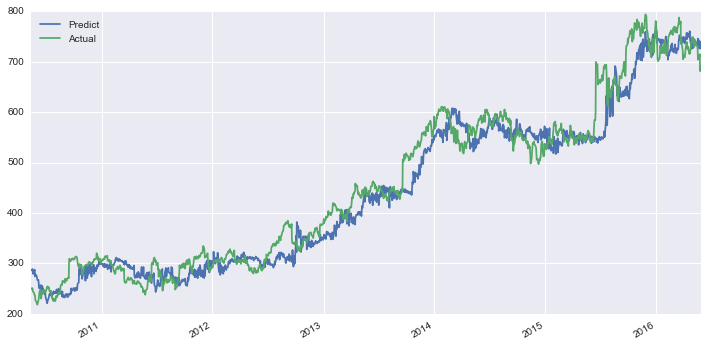

In [32]:
R2 = r2_score(test_y, pred_y)
MSE = mean_squared_error(test_y, pred_y)

print("R2: {}".format(R2))
print("MSE: {}".format(MSE))
dfResult4 = pred_y.join(test_y)
print(dfResult4.head())
print(dfResult4.tail())
dfResult4.columns = ['Predict', 'Actual']

dfResult4.plot(figsize=(12, 6))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
             Residual       GOOGL
2010-05-14  37.482480  249.244251
2010-05-17  35.205207  250.885883
2010-05-18  37.519026  250.290286
2010-05-19  38.515516  250.265262
2010-05-20  37.551548  244.524524
2010-05-21  35.431940  243.368366
2010-05-24  42.999000  241.266269
2010-05-25  48.417420  237.787784
2010-05-26  50.750742  236.576587
2010-05-27  37.702703  236.276279
2010-05-28  50.778780  227.357364
2010-06-01  53.099106  222.697696
2010-06-02  52.505503  219.964969
2010-06-03  50.614107  218.493503
2010-06-04  48.567072  218.253253
2010-06-07  42.034525  225.325336
2010-06-08  33.044538  228.508517
2010-06-09  18.879382  233.978976
2010-06-10  12.217717  238.153156
2010-06-11   5.403398  244.844852
2010-06-14  10.931938  245.915912
2010-06-15  -5.543048  247.257266
2010-06-16  18.949952  230.035037
2010-06-17  18.116123  233.323321
2010-06-18  15.082577  241.036044
2010-06-21  13.848851  238.988986
2010-06-

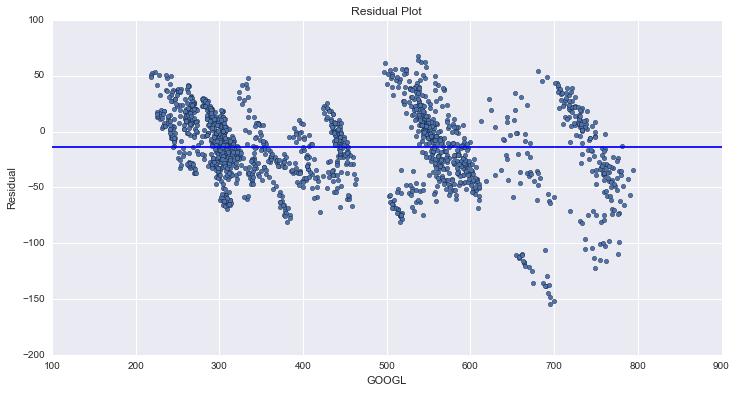

In [33]:
# print(pred_y)
# print(type(pred_y))
# print(type(test_y))
res = (pred_y['Predict'] - test_y)
# print(res)
print(type(res))
res = res.to_frame()
print(type(res))
# print(res)
res.columns = ['Residual']
res = res.join(test_y)
print(res)
# plt.plot_date(res.index, res['Residual'])
res.plot.scatter(x='GOOGL', y='Residual', title='Residual Plot', figsize=(12, 6))
plt.axhline(y=res['Residual'].mean())
plt.show()


In [34]:
print(data_X.columns)

Index([u'GOOGL_Vol', u'STLFSI', u'GOOGL_Std63d', u'GOOGL_Beta', u'GOOGL_EMA',
       u'GOOGL_SMA_Momentum', u'GOOGL_Vol_Momentum', u'GOOGL_SR63d',
       u'SPY_SMA_Momentum', u'SPY_Std63d', u'ARMA21d', u'Naive21d', u'SMA21d',
       u'Drift21d'],
      dtype='object')


count    1.779000e+03
mean     4.384328e+06
std      2.861513e+06
min      5.206000e+05
25%      2.381850e+06
50%      3.962000e+06
75%      5.474250e+06
max      2.961990e+07
Name: GOOGL_Vol, dtype: float64

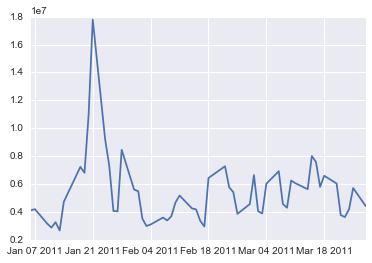

In [143]:
GOOGL_Vol = inv_sign_log(data_X['GOOGL_Vol'])
plt.plot(GOOGL_Vol[datetime(2011, 1, 6):datetime(2011, 3, 28)])
display(GOOGL_Vol.describe())

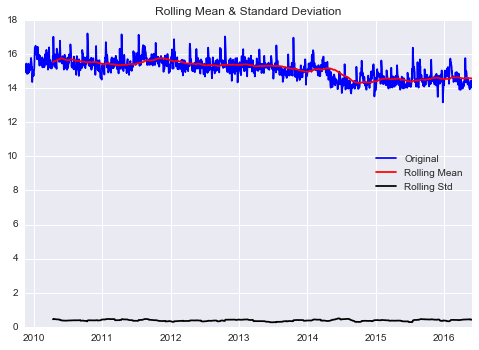

Results of Dickey-Fuller Test:
Test Statistic                   -2.538004
p-value                           0.106499
#Lags Used                       18.000000
Number of Observations Used    1623.000000
Critical Value (5%)              -2.863322
Critical Value (1%)              -3.434386
Critical Value (10%)             -2.567719
dtype: float64


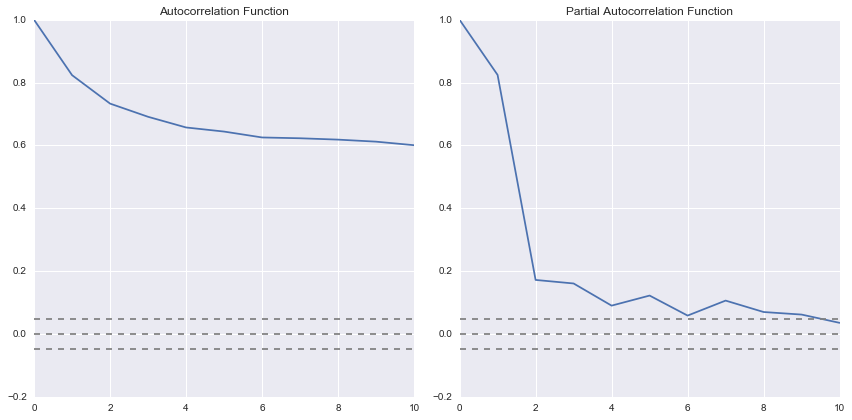

In [77]:
GOOGL_Vol_log = data_X['GOOGL_Vol']

test_stationarity(GOOGL_Vol_log)
plot_acf_pacf(GOOGL_Vol_log, 10)

In [78]:
GOOGL_Vol_log_diff = GOOGL_Vol_log - GOOGL_Vol_log.shift()
print(len(GOOGL_Vol_log))
print(len(GOOGL_Vol_log_diff))
print(GOOGL_Vol_log.head())
print(GOOGL_Vol_log_diff.head())

1642
1642
2009-11-18    14.945654
2009-11-19    15.281448
2009-11-20    15.203878
2009-11-23    15.442769
2009-11-24    14.980878
Name: GOOGL_Vol, dtype: float64
2009-11-18         NaN
2009-11-19    0.335794
2009-11-20   -0.077570
2009-11-23    0.238891
2009-11-24   -0.461891
Name: GOOGL_Vol, dtype: float64


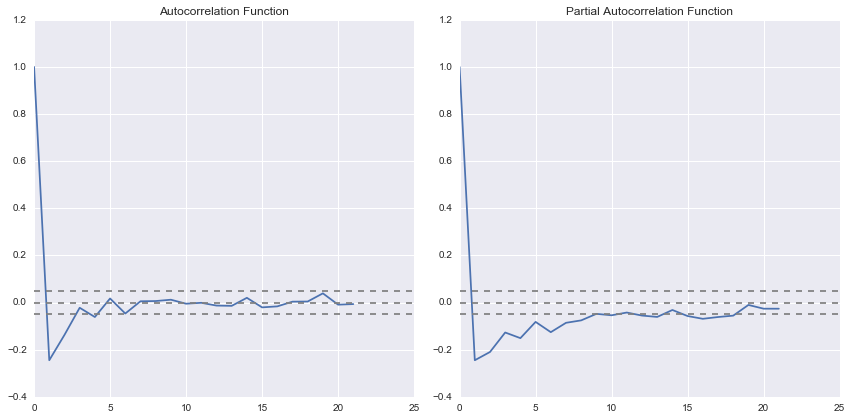

In [79]:
plot_acf_pacf(GOOGL_Vol_log_diff.dropna())

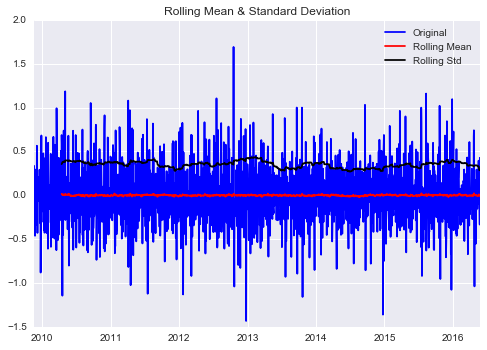

Results of Dickey-Fuller Test:
Test Statistic                -1.527382e+01
p-value                        4.677444e-28
#Lags Used                     1.700000e+01
Number of Observations Used    1.623000e+03
Critical Value (5%)           -2.863322e+00
Critical Value (1%)           -3.434386e+00
Critical Value (10%)          -2.567719e+00
dtype: float64


In [80]:
test_stationarity(GOOGL_Vol_log_diff.dropna())

In [83]:
GOOGL_Vol_log_diff.describe()

count    1641.000000
mean       -0.000352
std         0.348977
min        -1.433450
25%        -0.219778
50%        -0.022065
75%         0.204628
max         1.691295
Name: GOOGL_Vol, dtype: float64

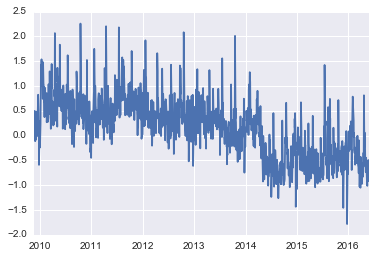

In [147]:
GOOGL_Vol_log_diff.dropna(inplace=True)

GOOGL_Vol_log_diff_cumsum = GOOGL_Vol_log_diff.cumsum()

GOOGL_Vol_log_diff_cumsum_df = GOOGL_Vol_log_diff_cumsum.to_frame()

plt.plot(GOOGL_Vol_log_diff_cumsum_df)


In [89]:
date_length = len(GOOGL_Vol_log_diff)
pred_list = []

for i in range(date_length - 257 + 1):
    model = ARMA(GOOGL_Vol_log_diff.ix[i:i+252], order=(8, 0))
    results_AR = model.fit(disp=-1)
    warnings.filterwarnings("ignore")
    pred_ARMA = results_AR.predict(start=len(results_AR.fittedvalues) - 1, end=len(results_AR.fittedvalues) + 5, dynamic=True)
    pred_list.append(pred_ARMA.iloc[-1])

print(len(GOOGL_Vol_log_diff))
print(len(pred_list))


1641
1385


2010-11-26   -0.016022
2010-11-29   -0.000716
2010-11-30   -0.022639
2010-12-01   -0.013101
2010-12-02   -0.009799
dtype: float64
2016-05-23   -0.006586
2016-05-24   -0.013081
2016-05-25   -0.007755
2016-05-26   -0.022852
2016-05-27    0.012893
dtype: float64
2010-11-26   -0.603129
2010-11-29    0.779866
2010-11-30    0.911835
2010-12-01   -0.639702
2010-12-02   -0.387568
Name: GOOGL_Vol, dtype: float64
2016-05-23   -0.334002
2016-05-24    0.426908
2016-05-25   -0.159952
2016-05-26   -0.215675
2016-05-27    0.292197
Name: GOOGL_Vol, dtype: float64


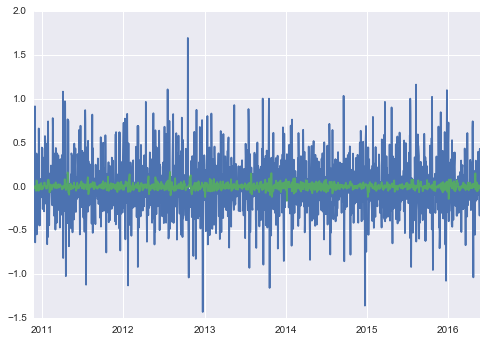

In [94]:
predictions_log_diff = pd.Series(pred_list, index=GOOGL_Vol_log_diff.index[256:], copy=True)
print(predictions_log_diff.head())
print(predictions_log_diff.tail())
print(GOOGL_Vol_log_diff.iloc[256:].head())
print(GOOGL_Vol_log_diff.iloc[256:].tail())

plt.plot(GOOGL_Vol_log_diff.iloc[256:])
plt.plot(predictions_log_diff)

            GOOGL_Vol  ARMA_Vol
2009-11-19   0.335794  0.335794
2009-11-20  -0.077570 -0.077570
2009-11-23   0.238891  0.238891
2009-11-24  -0.461891 -0.461891
2009-11-25  -0.093989 -0.093989
2009-11-27  -0.053831 -0.053831
2009-11-30   0.219870  0.219870
2009-12-01   0.296413  0.296413
2009-12-02  -0.332962 -0.332962
2009-12-03  -0.151971 -0.151971
2009-12-04   0.564951  0.564951
2009-12-07  -0.429333 -0.429333
2009-12-08  -0.071047 -0.071047
2009-12-09   0.155843  0.155843
2009-12-10  -0.065378 -0.065378
2009-12-11   0.030521  0.030521
2009-12-14   0.106556  0.106556
2009-12-15   0.175480  0.175480
2009-12-16   0.208614  0.208614
2009-12-17  -0.062636 -0.062636
2009-12-18   0.291397  0.291397
2009-12-21  -0.317356 -0.317356
2009-12-22  -0.312674 -0.312674
2009-12-23   0.097152  0.097152
2009-12-24  -0.881222 -0.881222
2009-12-28   0.681774  0.681774
2009-12-29  -0.175377 -0.175377
2009-12-30   0.028227  0.028227
2009-12-31  -0.183579 -0.183579
2010-01-04   0.472319  0.472319
...     

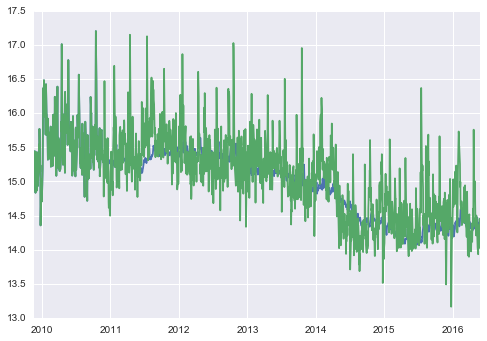

In [95]:
GOOGL_Vol_log_diff_df = GOOGL_Vol_log_diff.to_frame()

GOOGL_Vol_log_diff_df['ARMA_Vol'] = predictions_log_diff

GOOGL_Vol_log_diff_df['ARMA_Vol'].fillna(GOOGL_Vol_log_diff_df['GOOGL_Vol'], inplace=True)

print(GOOGL_Vol_log_diff_df)

predictions_log_diff = GOOGL_Vol_log_diff_df['ARMA_Vol']

GOOGL_Vol_log_addback = GOOGL_Vol_log_diff_df['GOOGL_Vol'].cumsum() + GOOGL_Vol_log.ix[0]
predictions_log = predictions_log_diff.cumsum() + GOOGL_Vol_log.ix[0]
print(GOOGL_Vol_log_addback.head())
print(GOOGL_Vol_log[1:].head())
print(predictions_log.head())

print(GOOGL_Vol_log_addback.tail())
print(GOOGL_Vol_log[1:].tail())
print(predictions_log.tail())

plt.plot(predictions_log)
plt.plot(GOOGL_Vol_log)

0.579080751215
0.457294814507


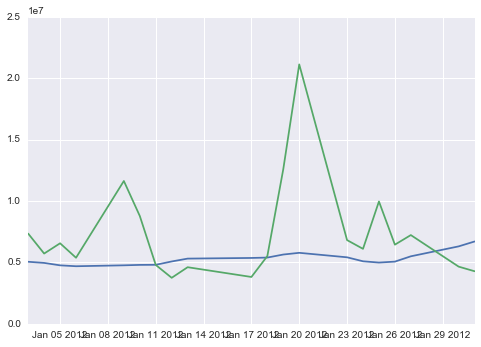

In [108]:
# plt.plot(predictions_log[datetime(2014, 1, 1):datetime(2014, 1, 15)])
# plt.plot(GOOGL_Vol_log[datetime(2014, 1, 1):datetime(2014, 1, 15)])



predictions = inv_sign_log(predictions_log)
GOOGL_Vol = inv_sign_log(GOOGL_Vol_log)

# plt.plot(predictions)
# plt.plot(GOOGL_Vol)

plt.plot(predictions[datetime(2012, 1, 1):datetime(2012, 1, 31)])
plt.plot(GOOGL_Vol[datetime(2012, 1, 1):datetime(2012, 1, 31)])

print(r2_score(GOOGL_Vol_log[1:], predictions_log))
print(r2_score(GOOGL_Vol[1:], predictions))
# (u,) = predictions_log.index.get_indexer_for([datetime(2014, 1, 1)])
# print(u)

In [ ]:
plt.plot(GOOGL_Vol[:251])